In [181]:
import gpytorch
import torch

from tqdm.autonotebook import tqdm
import numpy as np
import itertools
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [182]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [183]:
df = pd.read_csv("data.csv")
df

Time post-injection (months) MBSC Region       iM2       iM1       iAI  \
0                              1         NTG  0.014842  0.000000  0.003629   
1                              1         NTG  0.227463  0.016372  0.139844   
2                              1         NTG  0.266335  0.008691  0.028367   
3                              1         NTG  0.042362  0.005238  0.044917   
4                              1         G20  0.023577  0.004621  0.003638   
5                              1         G20  0.324371  0.036880  0.071656   
6                              1         G20  0.016340  0.000567  0.004682   
7                              1         G20  0.135917  0.013436  0.040500   
8                              1         G20  0.058894  0.002256  0.010915   
9                              1         G20  0.103370  0.034662  0.061016   
10                             3         NTG  0.226238  0.035277  0.047919   
11                             3         NTG  0.265136  0.033279  0.036167   
12                             3         NTG  0.166492  0.072561  0.031884   
13                             3         NTG  0.110787  0.010213  0.007480   
14                             3         NTG  0.068278  0.013561  0.006797   
15                             3         NTG  0.121728  0.022373  0.024656   
16                             3         G20  0.087401  0.014916  0.034780   
17                             3         G20  0.200184  0.050143  0.088147   
18                             3         G20  0.077960  0.015269  0.023336   
19                             3         G20  0.226932  0.033087  0.059765   
20                             3         G20  0.028669  0.033327  0.018061   
21                             3         G20  0.108555  0.004217  0.017198   
22                             6         NTG  0.139548  0.055144  0.038464   
23                             6         NTG  0.116827  0.017634  0.015608   
24                             6         NTG  0.050864  0.004190  0.004890   
25                             6         NTG  0.114184  0.052964  0.047764   
26                             6         NTG  0.103685  0.024596  0.026256   
27                             6         NTG  0.159169  0.019484  0.007290   
28                             6         G20  0.115875  0.035139  0.087668   
29                             6         G20  0.134469  0.017152  0.037447   
30                             6         G20  0.078981  0.036773  0.044627   
31                             6         G20  0.053576  0.011991  0.009175   
32                             6         G20  0.240193  0.073334  0.047894   
33                             6         G20       NaN       NaN       NaN   
34                             6         G20  0.224684  0.066283  0.031809   

        iPrL       iMO       iVO       iDP       cM2  ...      iSuC       iIC  \
0   0.006650  0.000000  0.011567  0.000189  0.001134  ...  0.000000  0.002816   
1   0.044689  0.002673  0.015362  0.016991  0.026859  ...  0.000000  0.002742   
2   0.092924  0.009293  0.009727  0.010178  0.021157  ...  0.000000  0.002642   
3   0.021161  0.002880  0.001877  0.010599  0.021431  ...  0.000000  0.000833   
4   0.000000  0.001450  0.000000  0.000941  0.005575  ...  0.000000  0.000332   
5   0.011516  0.001394  0.005631  0.002850  0.096962  ...  0.000000  0.000495   
6   0.000214  0.000276  0.003756  0.000000  0.010201  ...  0.000080  0.004816   
7   0.043342  0.000000  0.003332  0.017234  0.041776  ...  0.000059  0.000417   
8   0.024721  0.013671  0.023185  0.002531  0.015196  ...  0.000054  0.001459   
9   0.004168  0.001304  0.000341  0.006339  0.151783  ...  0.000000  0.000812   
10  0.036377  0.005736  0.040974  0.038426  0.084717  ...  0.000000  0.000583   
11  0.014793  0.007199  0.034637  0.010601  0.124545  ...  0.000141  0.001631   
12  0.006134  0.003214  0.021245  0.005029  0.037701  ...  0.000000  0.000000   
13  0.016690  0.008226  0.015667  0.032898  0.024719  ...  0.

$$y  = f(\mathbf x)$$

$$Y \sim GP(\mathbf X)$$

In [184]:
y = df[df["MBSC Region"] == "NTG"]
y = y.drop(["Time post-injection (months)", "MBSC Region"], axis=1)
y

iM2       iM1       iAI      iPrL       iMO       iVO       iDP  \
0   0.014842  0.000000  0.003629  0.006650  0.000000  0.011567  0.000189   
1   0.227463  0.016372  0.139844  0.044689  0.002673  0.015362  0.016991   
2   0.266335  0.008691  0.028367  0.092924  0.009293  0.009727  0.010178   
3   0.042362  0.005238  0.044917  0.021161  0.002880  0.001877  0.010599   
10  0.226238  0.035277  0.047919  0.036377  0.005736  0.040974  0.038426   
11  0.265136  0.033279  0.036167  0.014793  0.007199  0.034637  0.010601   
12  0.166492  0.072561  0.031884  0.006134  0.003214  0.021245  0.005029   
13  0.110787  0.010213  0.007480  0.016690  0.008226  0.015667  0.032898   
14  0.068278  0.013561  0.006797  0.001279  0.001372  0.021749  0.018987   
15  0.121728  0.022373  0.024656  0.008343  0.005911  0.026618  0.034573   
22  0.139548  0.055144  0.038464  0.023560  0.004000  0.040783  0.041923   
23  0.116827  0.017634  0.015608  0.021780  0.014831  0.013789  0.006675   
24  0.050864  0.004190  0.004890  0.019028  0.014178  0.002902  0.002011   
25  0.114184  0.052964  0.047764  0.002244  0.000164  0.031226  0.008775   
26  0.103685  0.024596  0.026256  0.006280  0.002063  0.033713  0.020542   
27  0.159169  0.019484  0.007290  0.033106  0.000000  0.071320  0.056711   

         cM2       cM1       cAI  ...      iSuC       iIC      iPnO      cV-b  \
0   0.001134  0.000652  0.001712  ...  0.000000  0.002816  0.000000  0.000000   
1   0.026859  0.043122  0.098335  ...  0.000000  0.002742  0.000483  0.000000   
2   0.021157  0.000372  0.023335  ...  0.000000  0.002642  0.000739  0.000193   
3   0.021431  0.002027  0.008200  ...  0.000000  0.000833  0.000566  0.000540   
10  0.084717  0.028549  0.070629  ...  0.000000  0.000583  0.002342  0.001512   
11  0.124545  0.040443  0.049934  ...  0.000141  0.001631  0.000000  0.000123   
12  0.037701  0.029983  0.018974  ...  0.000000  0.000000  0.001196  0.000151   
13  0.024719  0.001127  0.020188  ...  0.000000  0.000032  0.000308  0.000925   
14  0.021663  0.012344  0.012465  ...  0.000000  0.000000  0.000437  0.000000   
15  0.016354  0.006356  0.014647  ...  0.000087  0.001711  0.000000  0.000000   
22  0.049713  0.025357  0.047622  ...  0.000031  0.002560  0.000558  0.000000   
23  0.054854  0.004353  0.018395  ...  0.000035  0.000083  0.000029  0.003436   
24  0.011966  0.000328  0.008826  ...  0.001128  0.000714  0.000107  0.002719   
25  0.053515  0.015943  0.020596  ...  0.001191  0.000031  0.000381  0.000129   
26  0.041941  0.021111  0.025686  ...  0.000000  0.000253  0.000025  0.002331   
27  0.030832  0.007879  0.018049  ...  0.000000  0.000000  0.000000  0.007274   

        cEnt       cPS  cRSA      cSuC       cIC      cPnO  
0   0.000078  0.000164   0.0  0.000000  0.000000  0.000108  
1   0.000000  0.000000   0.0  0.000000  0.000000  0.000071  
2   0.002247  0.000000   0.0  0.000206  0.000038  0.000079  
3   0.000000  0.001798   0.0  0.000000  0.000000  0.000000  
10  0.005215  0.000047   0.0  0.000886  0.000000  0.000508  
11  0.000733  0.000000   0.0  0.000000  0.000251  0.000000  
12  0.000877  0.000575   0.0  0.000000  0.000035  0.000000  
13  0.001419  0.000379   0.0  0.000095  0.000000  0.000000  
14  0.000000  0.000000   0.0  0.000000  0.000000  0.000023  
15  0.000662  0.000000   0.0  0.000000  0.000000  0.020382  
22  0.000030  0.000547   0.0  0.000000  0.000680  0.000214  
23  0.000707  0.000054   0.0  0.000000  0.000288  0.000903  
24  0.000000  0.000000   0.0  0.000000  0.000000  0.000000  
25  0.003285  0.000284   0.0  0.000000  0.000000  0.000034  
26  0.001180  0.000000   0.0  0.000000  0.000000  0.000019  
27  0.000000  0.000202   0.0  0.000000  0.000000  0.000000  

[16 rows x 116 columns]

In [185]:
for c in y.columns:
    if len(y[c].unique()) == 1:
        y.drop(c, axis=1, inplace=True)
        print(f"I droped {c}")

I droped cRSA


In [186]:
y_data = y.values.astype(np.float32)
y_shape = y.shape
y = torch.from_numpy(y_data.flatten()).reshape(*y.shape)
y = torch.log(y+1e-04)

for i in range(y.shape[1]):
    y[:,i] = (y[:,i] - torch.mean(y[:,i])) / torch.std(y[:,i])
y

tensor([[-2.6375, -3.2009, -1.7215,  ..., -0.4061, -0.5194, -0.0629],
        [ 0.9386,  0.1037,  1.8959,  ..., -0.4061, -0.5194, -0.2046],
        [ 1.1457, -0.3028,  0.3068,  ...,  1.3761, -0.0100, -0.1712],
        ...,
        [ 0.0341,  0.8611,  0.8253,  ..., -0.4061, -0.5194, -0.3782],
        [-0.0924,  0.3659,  0.2299,  ..., -0.4061, -0.5194, -0.4638],
        [ 0.4700,  0.2157, -1.0390,  ..., -0.4061, -0.5194, -0.5911]])

In [190]:
x = df.loc[df["MBSC Region"] == "NTG", "Time post-injection (months)"].values
x = torch.from_numpy(x.astype(np.float32))
x = x - x.mean() / x.std()

In [191]:
train_x = x
train_y =  y
print(train_x.shape)
print(train_y.shape)
print(train_x.dtype)
print(train_y.dtype)
print(train_x)
print(train_x.stride())
print(train_y.stride())

torch.Size([16])
torch.Size([16, 115])
torch.float32
torch.float32
tensor([-0.7584, -0.7584, -0.7584, -0.7584,  1.2416,  1.2416,  1.2416,  1.2416,
         1.2416,  1.2416,  4.2416,  4.2416,  4.2416,  4.2416,  4.2416,  4.2416])
(1,)
(115, 1)


In [192]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [196]:
all_ = list(range(3))
all_.remove(1)
all_

[0, 2]

In [199]:
n = train_x.shape[0]

for i in range(n):
    
    all_ = list(range(n))
    all_.remove(i)
    train_x = x[all_]
    train_y = y[all_]
    
    num_tasks = train_y.shape[-1]
    print("num tasks:", num_tasks)

    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks)
    model = MultitaskGPModel(train_x, train_y, likelihood, num_tasks=num_tasks)


    # Number of epochs
    epochs = 1000


    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    hist_loss = []

    with tqdm(total=epochs) as pbar:

        for i in range(epochs):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)
            loss.backward()

            hist_loss.append(loss.item())

            # model.covar_module.base_kernel.lengthscale.item(),
            # model.likelihood.noise.item()
            optimizer.step()

            pbar.set_postfix(loss=loss.item())
            pbar.update()
            
    break

num tasks: 115


  0%|          | 0/1000 [00:00<?, ?it/s]

In [204]:
test_x = torch.linspace(x.min(), x.max(), 50)

In [205]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

In [208]:
column = list(df.columns)
column.remove("Time post-injection (months)")
column.remove("cRSA")
column.remove("MBSC Region")

In [209]:
want_to_see = column.index("iCPu")

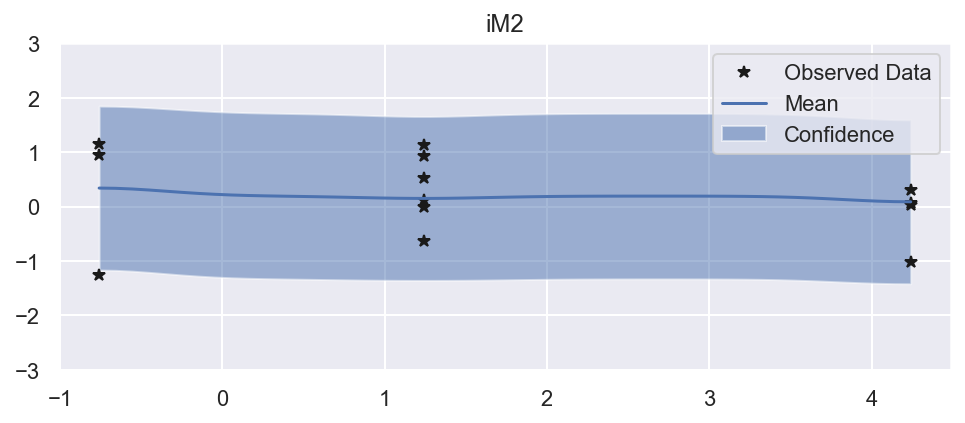

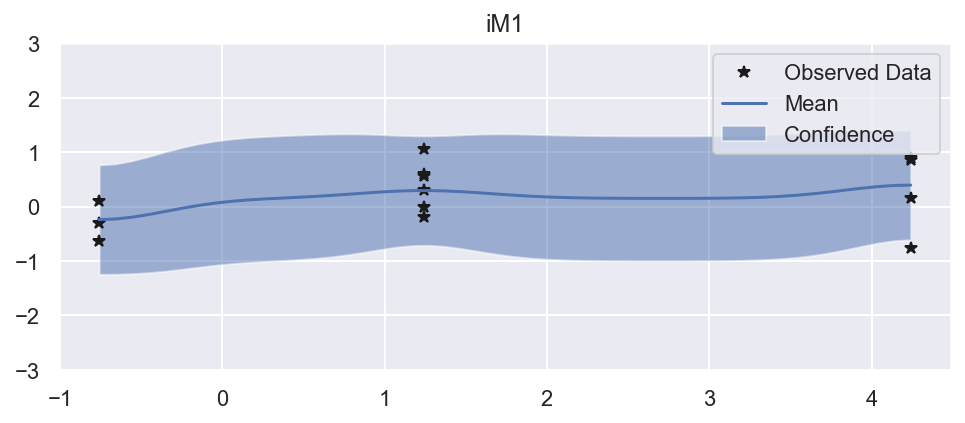

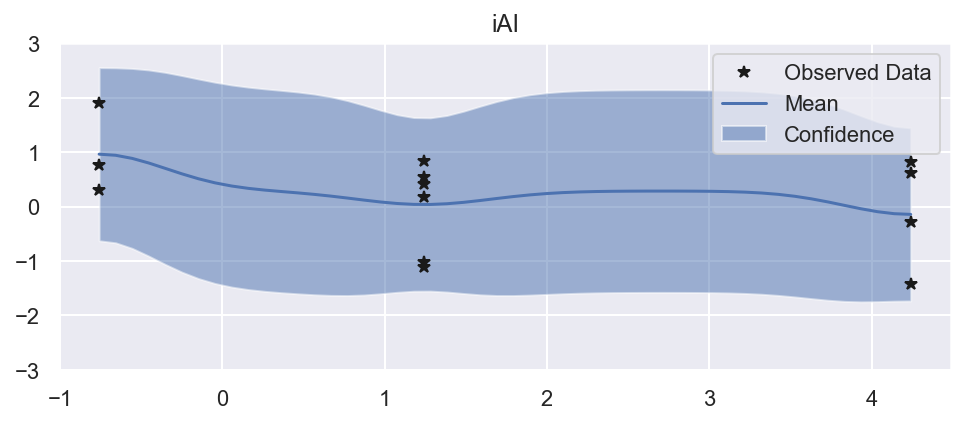

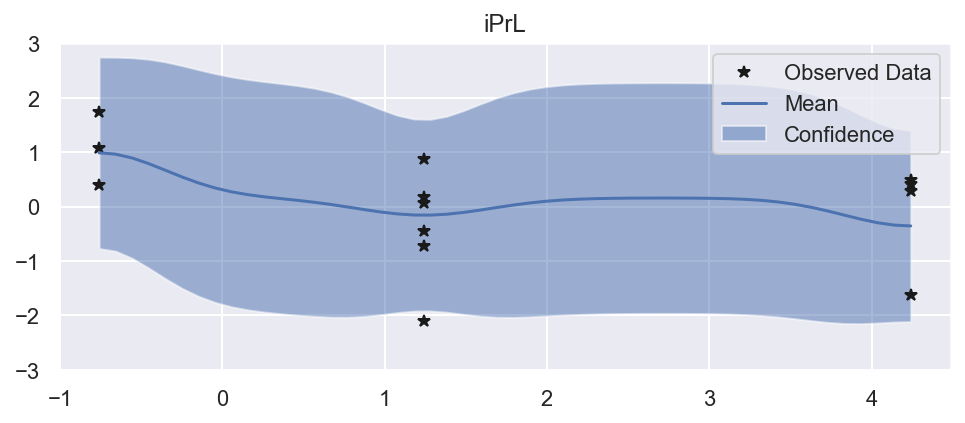

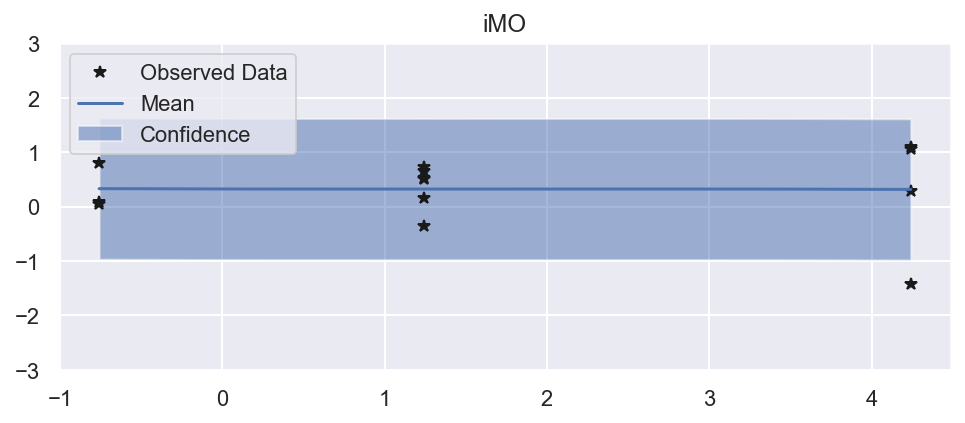

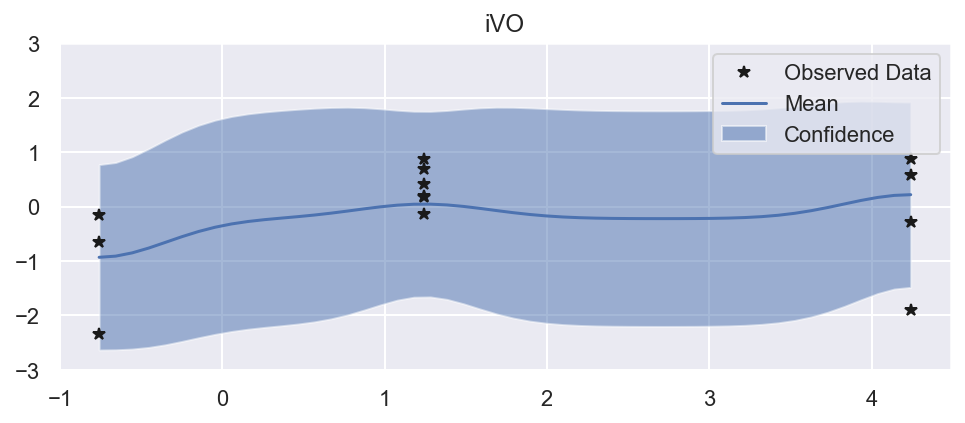

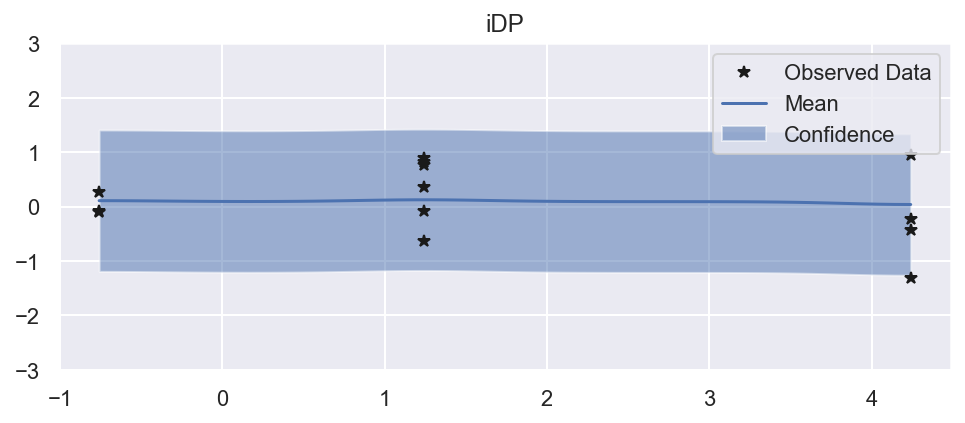

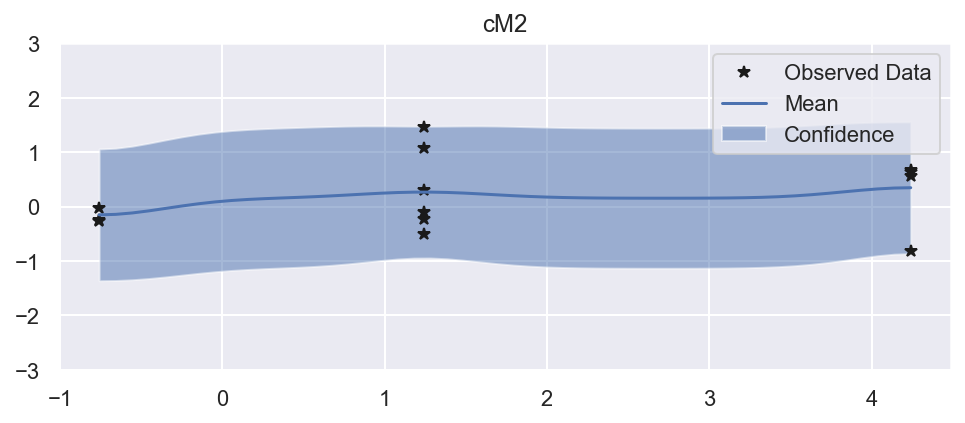

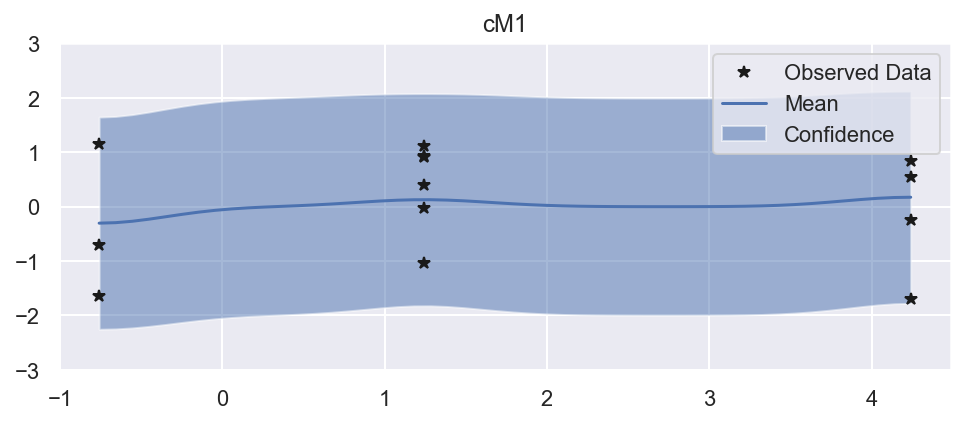

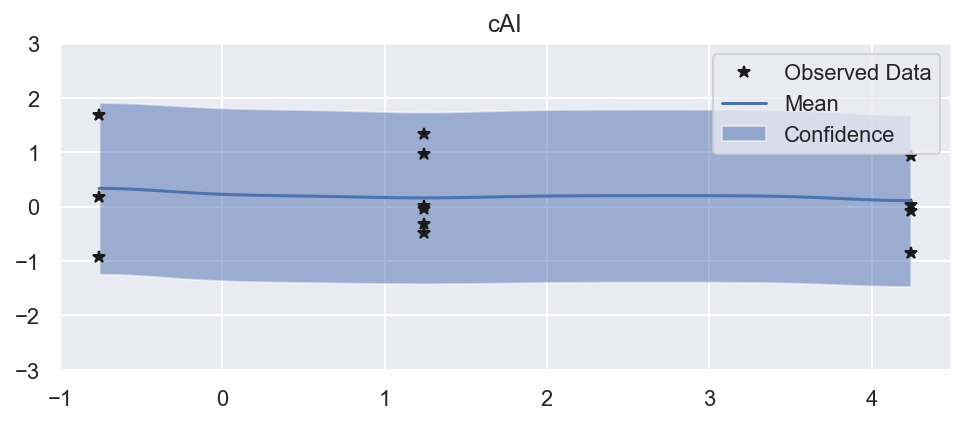

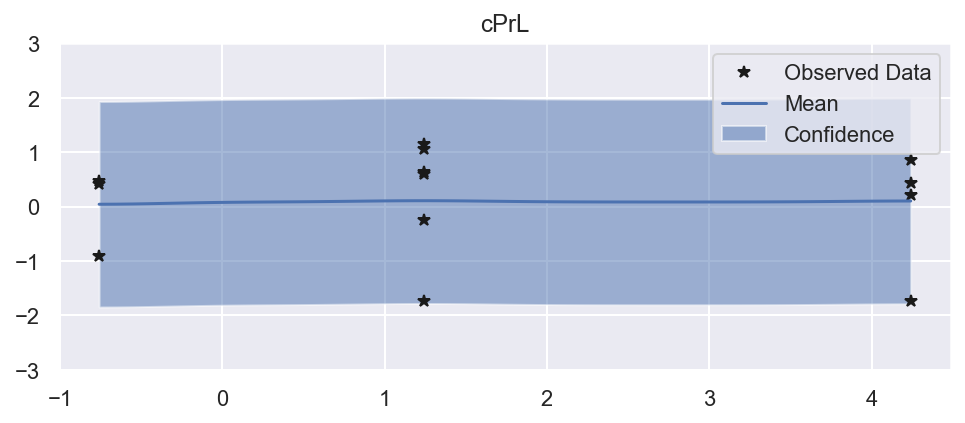

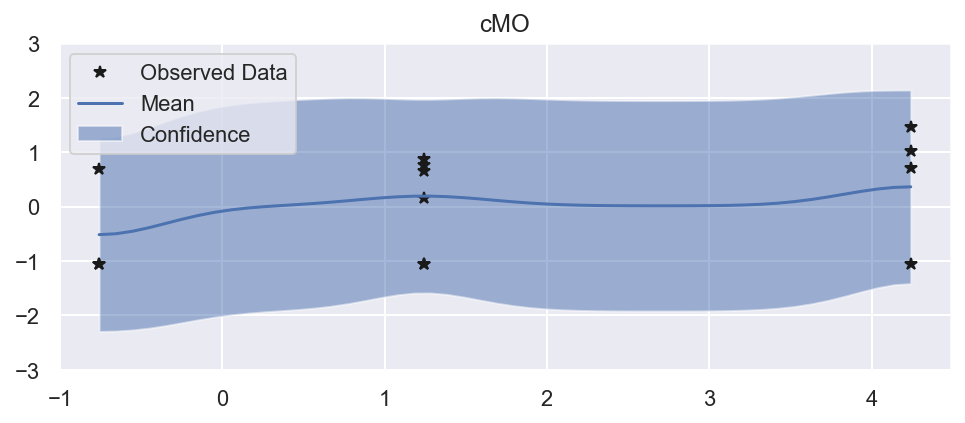

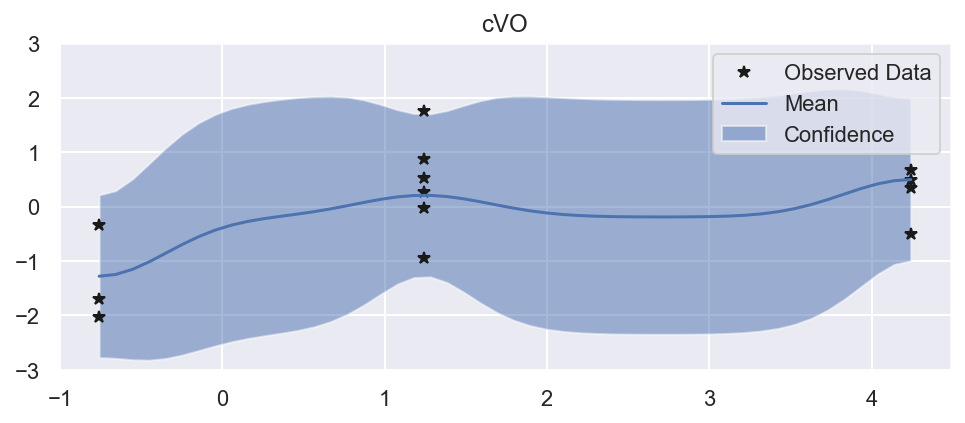

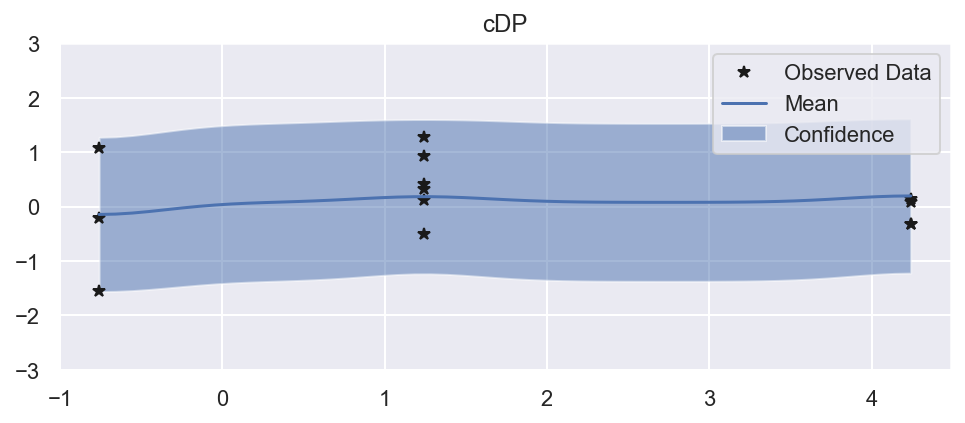

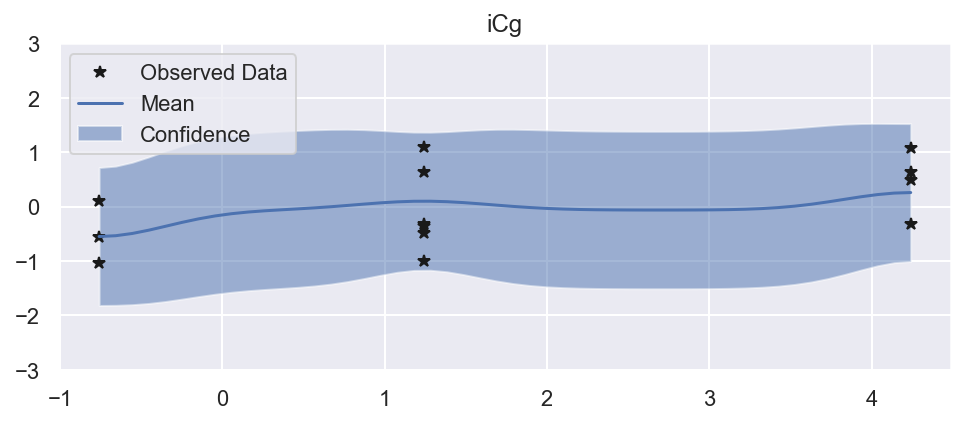

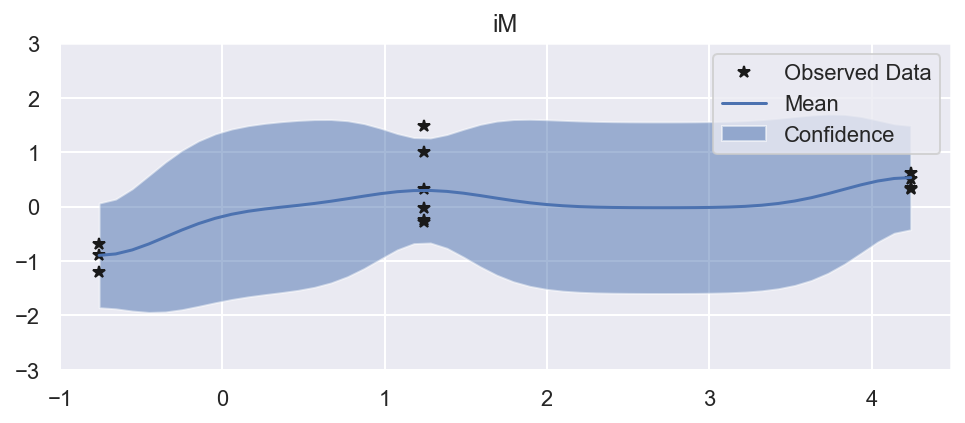

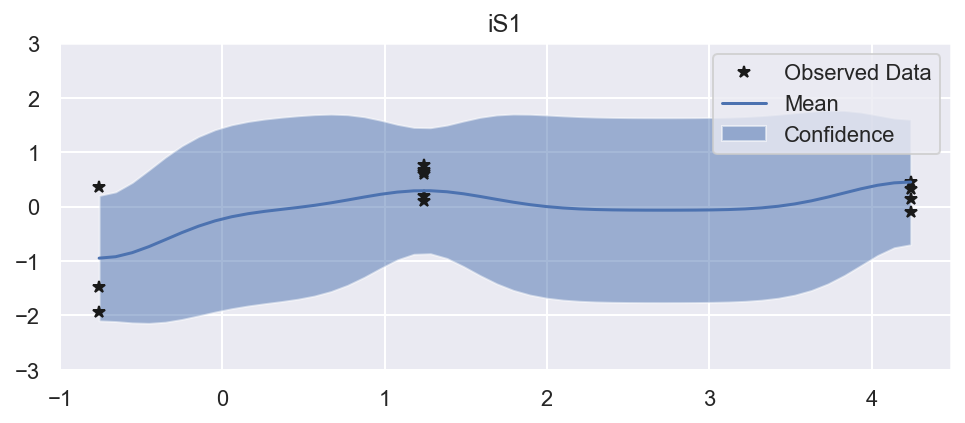

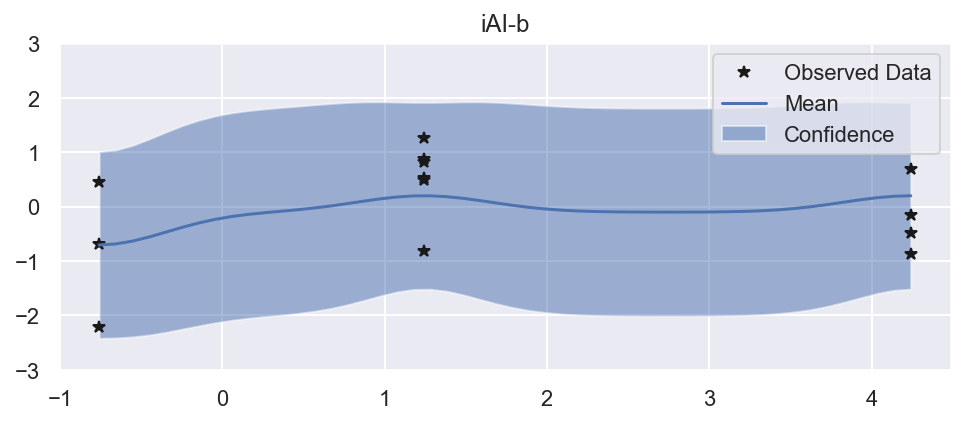

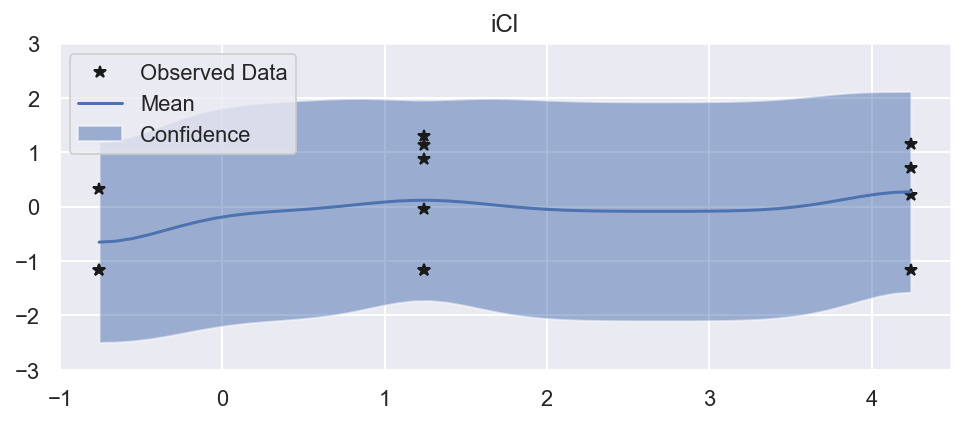

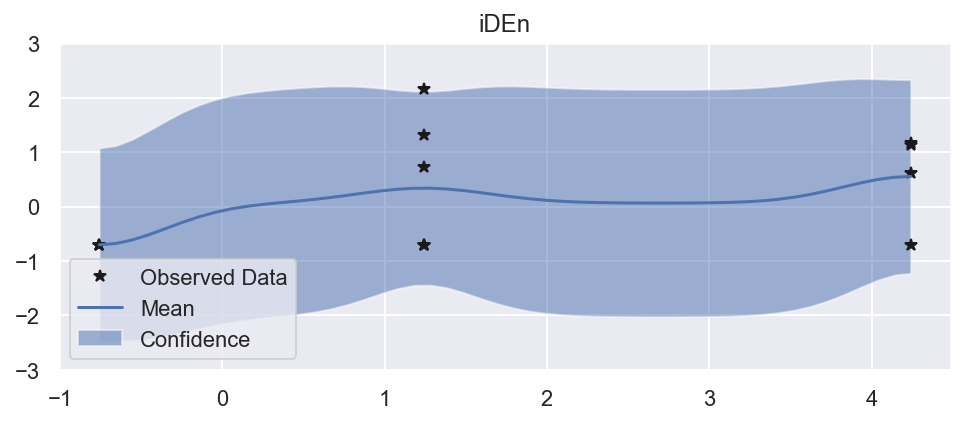

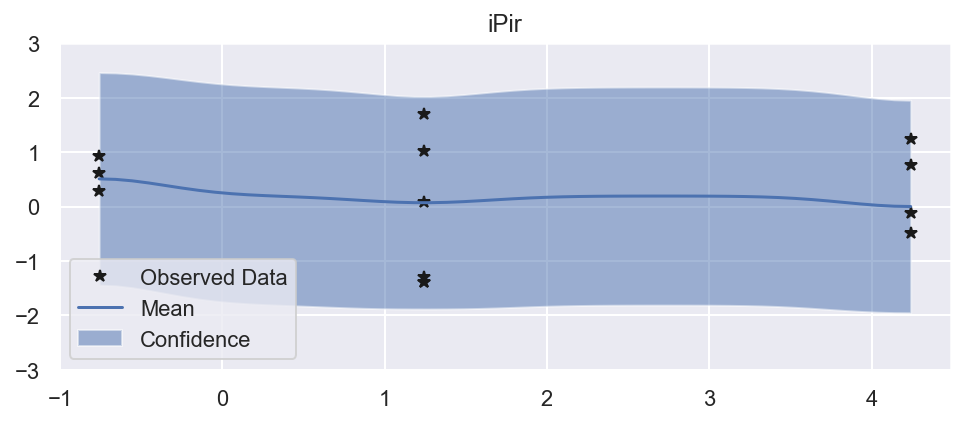

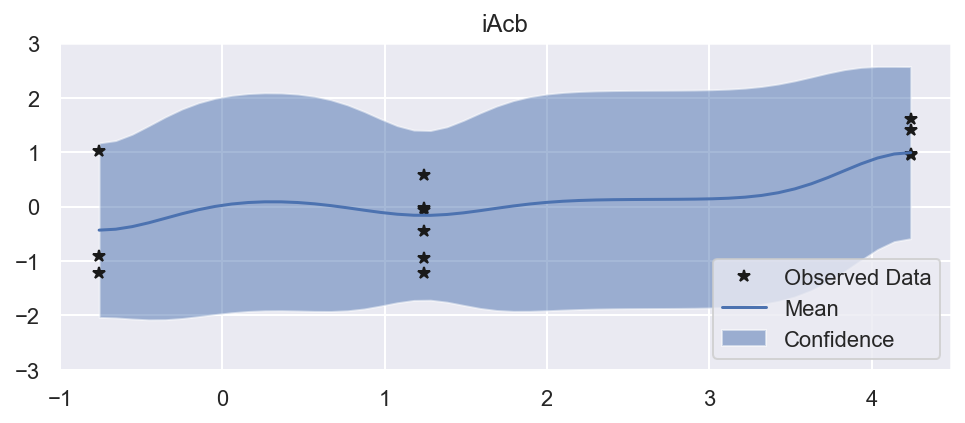

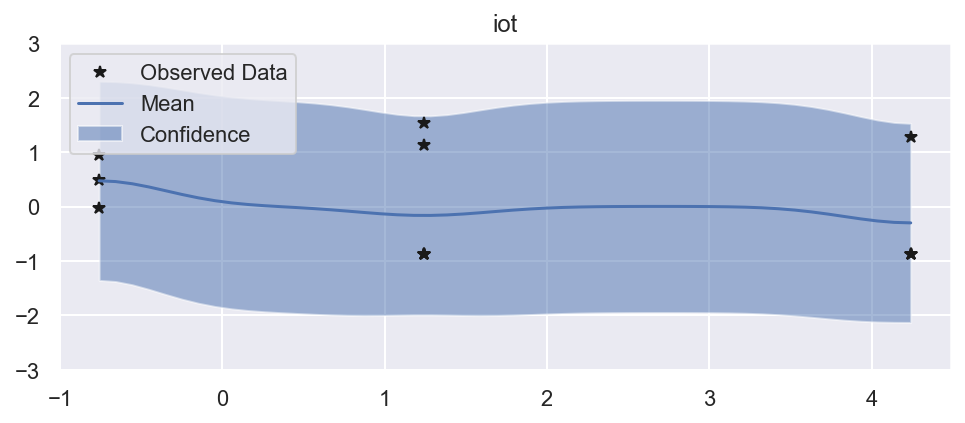

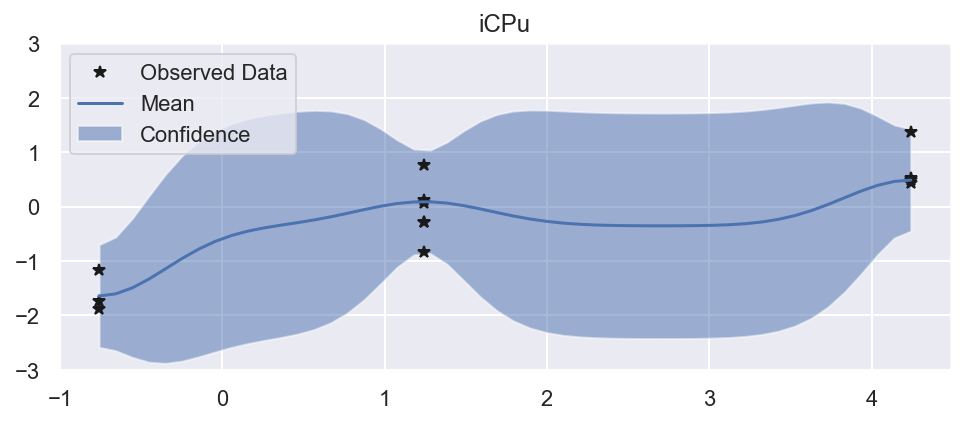

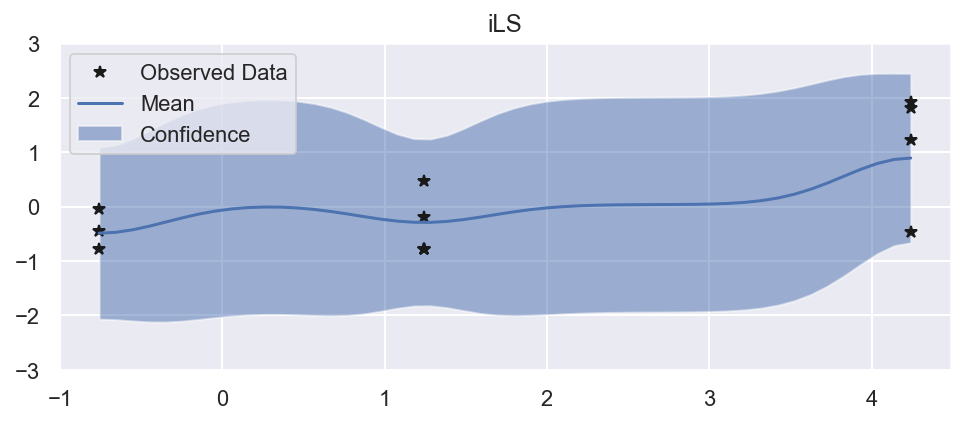

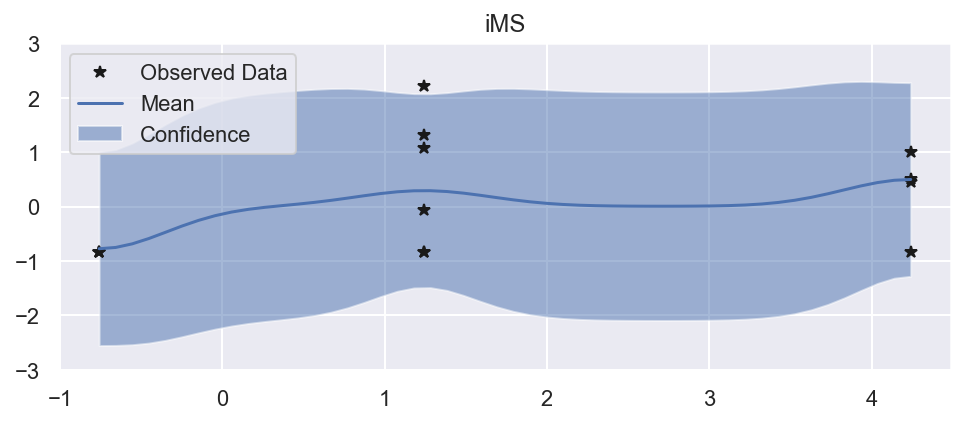

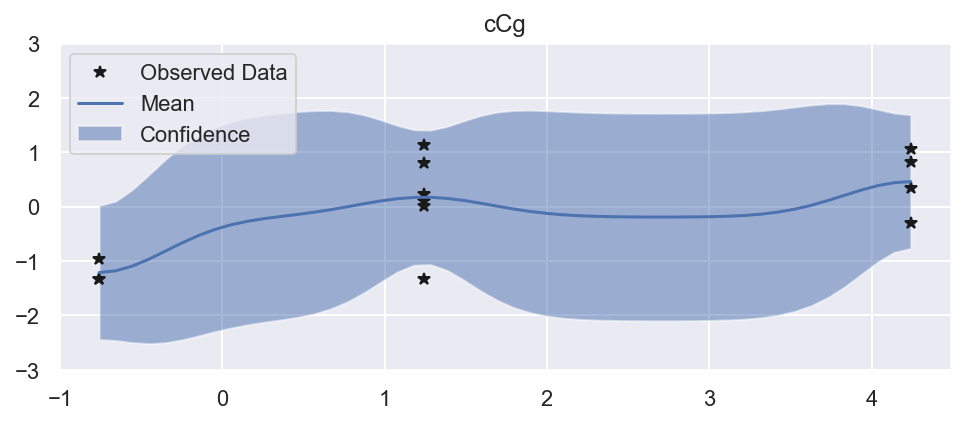

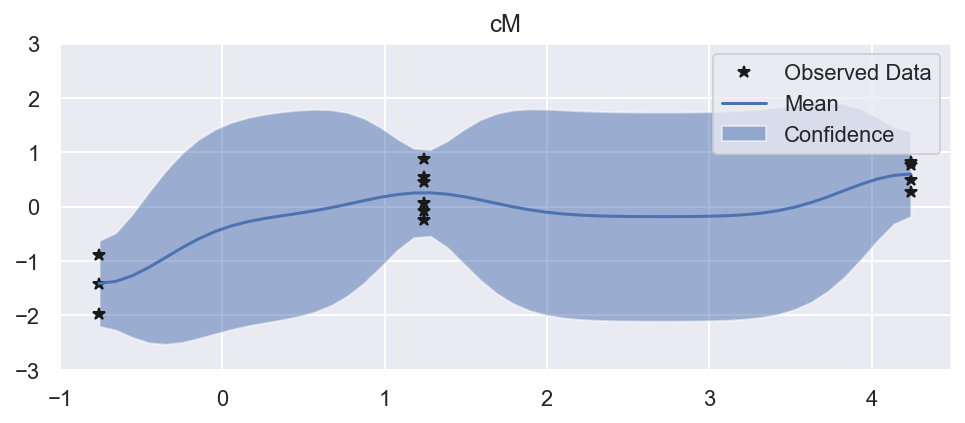

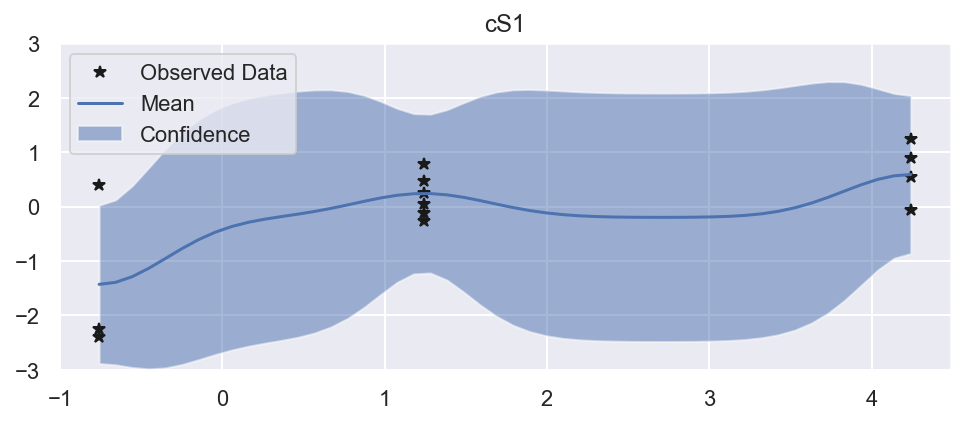

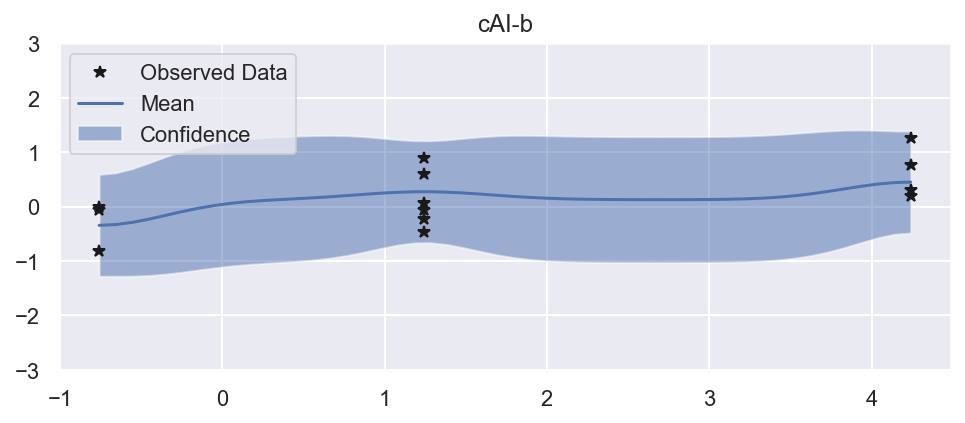

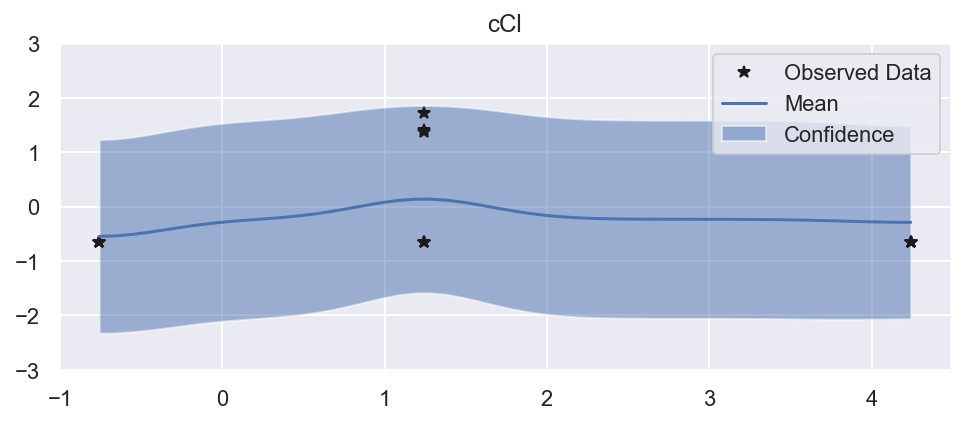

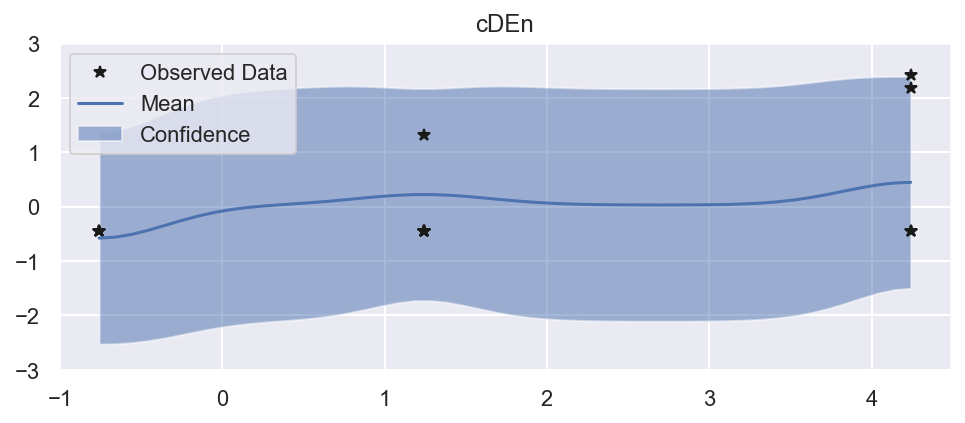

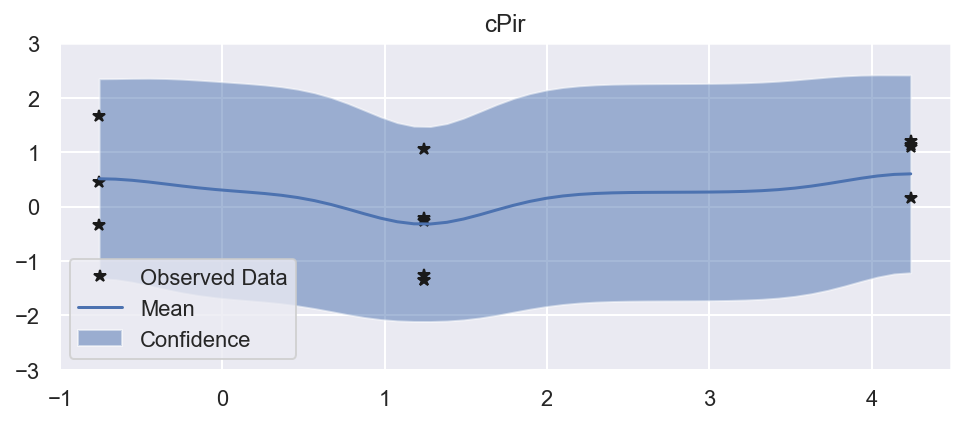

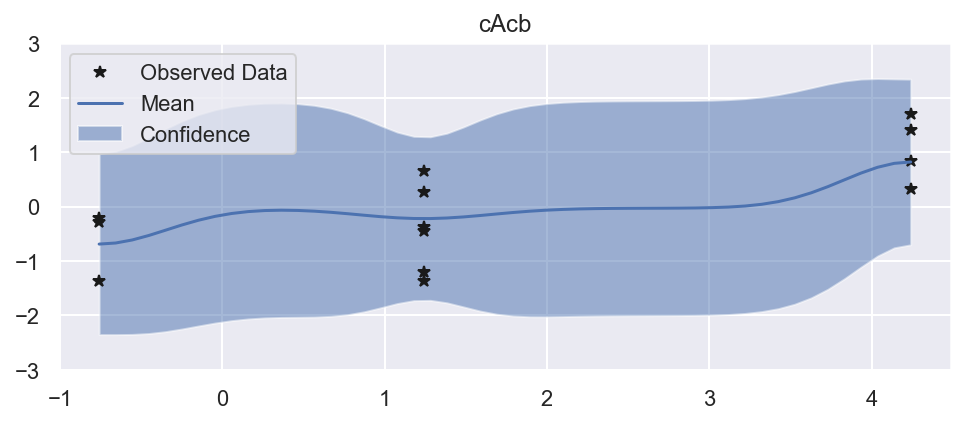

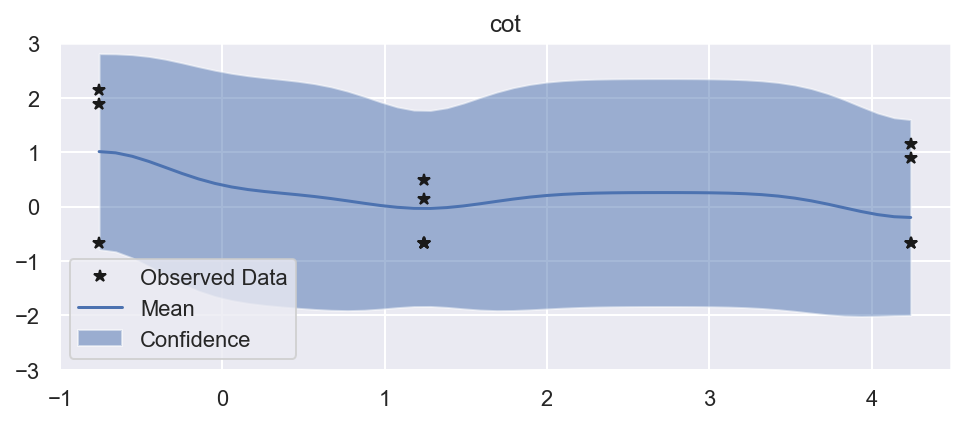

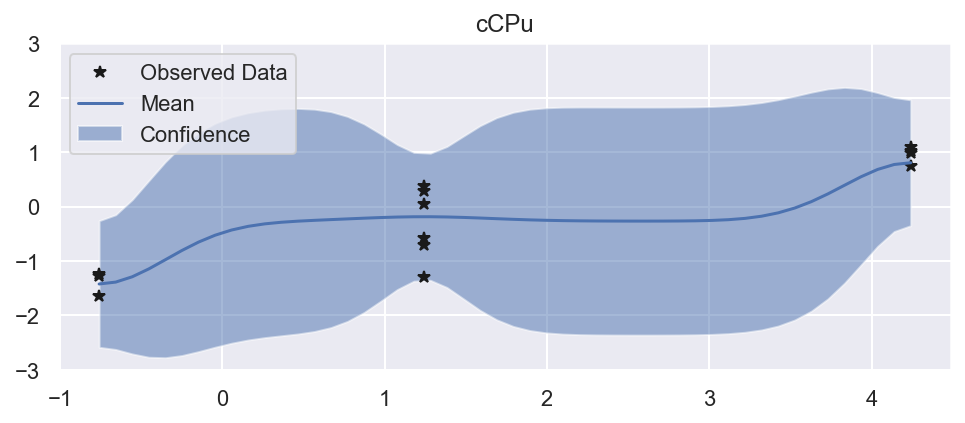

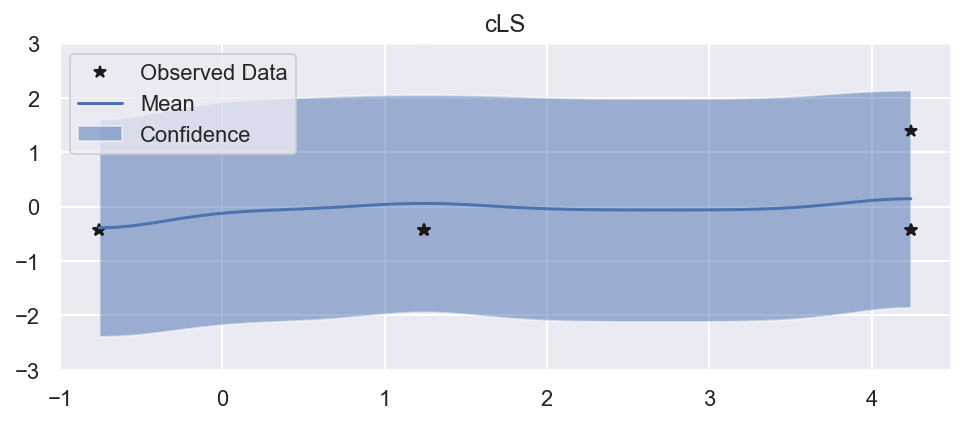

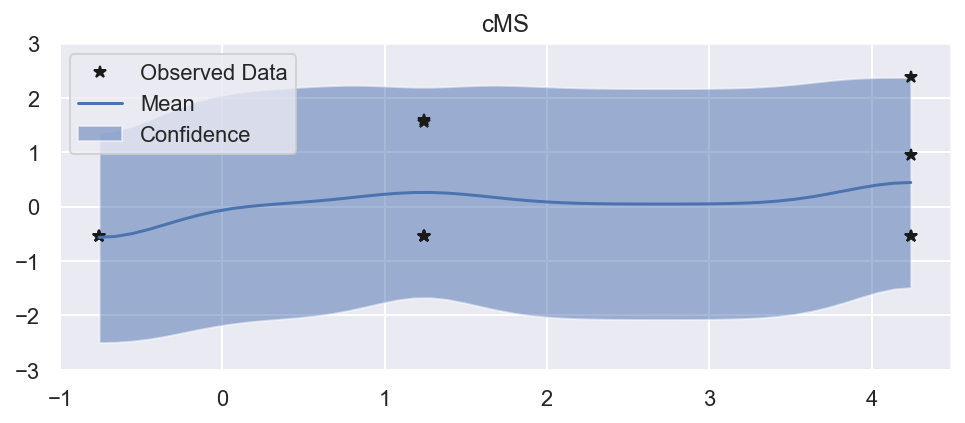

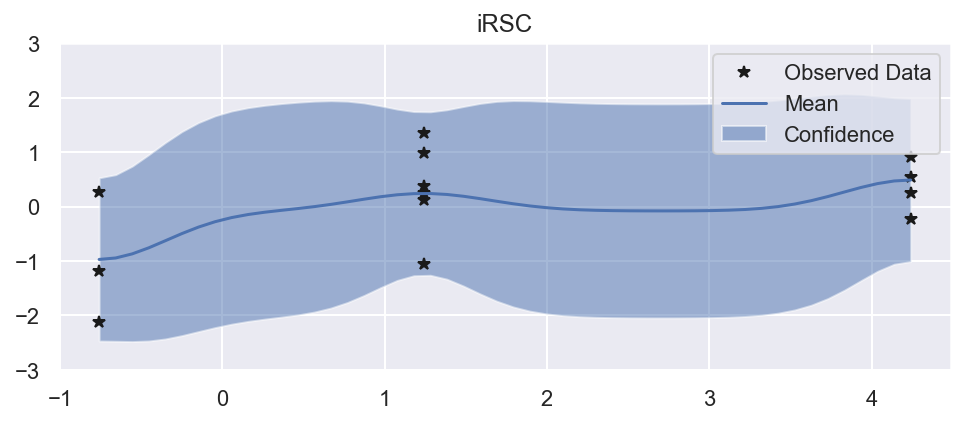

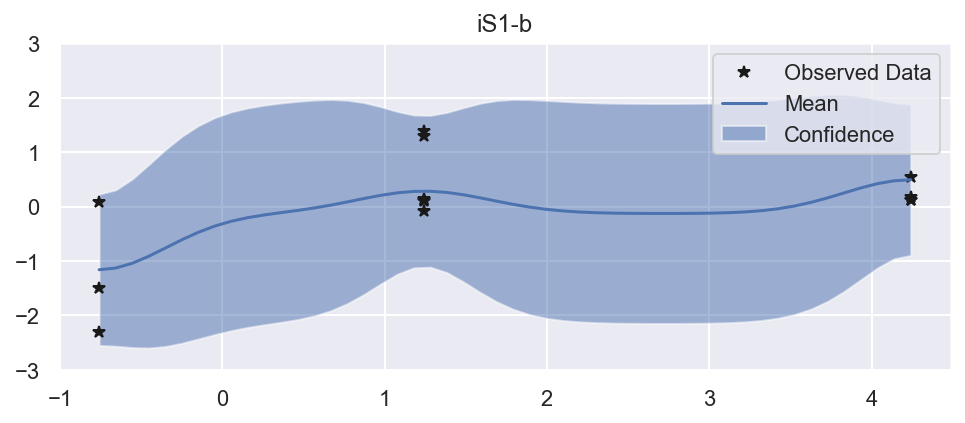

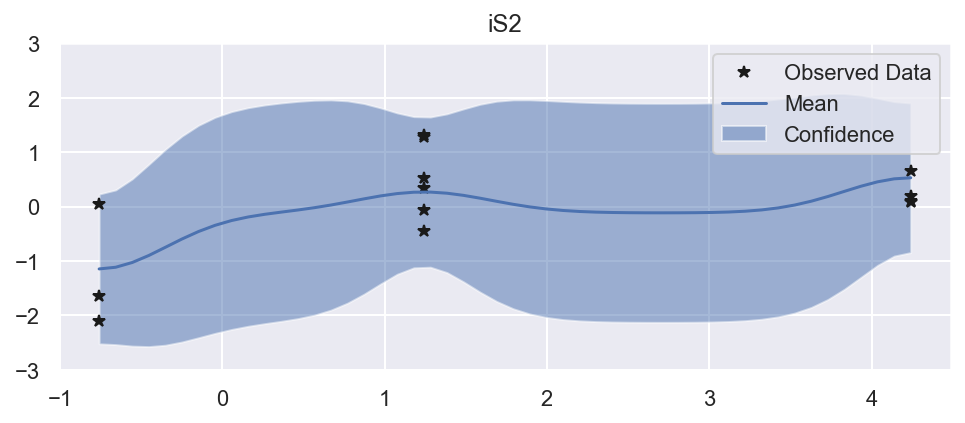

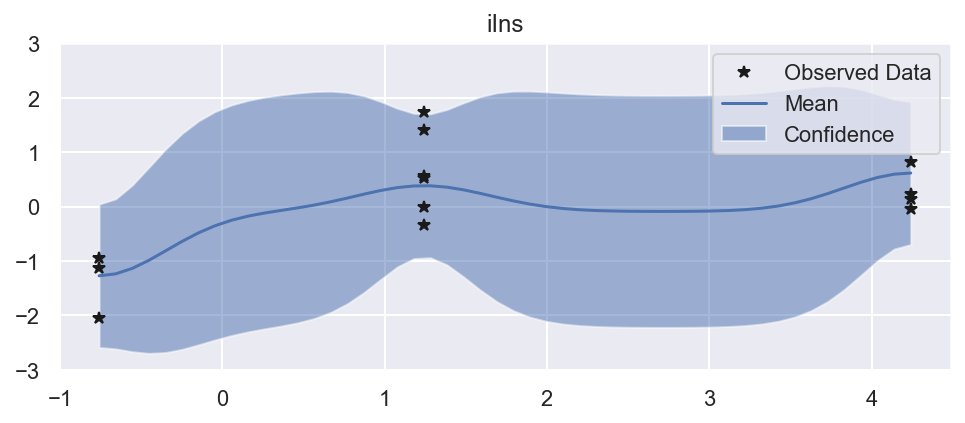

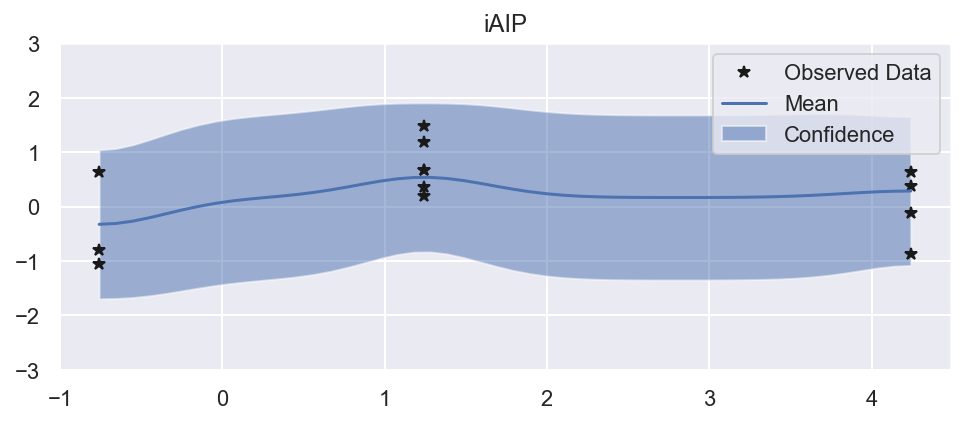

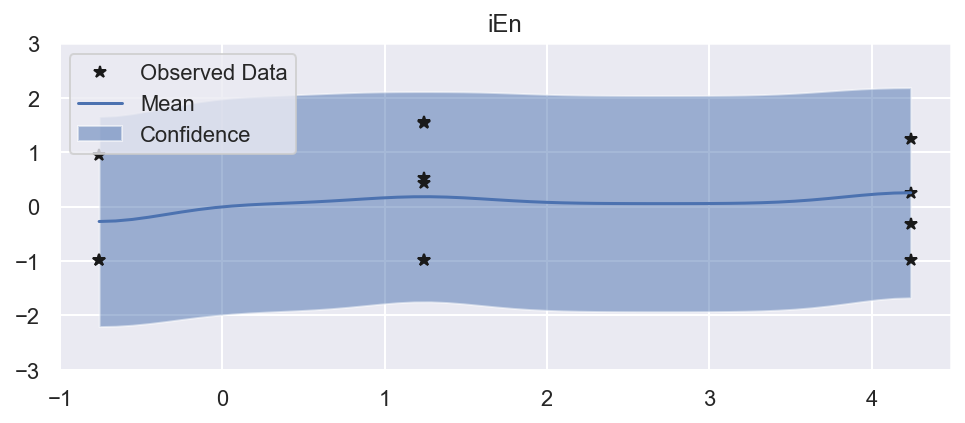

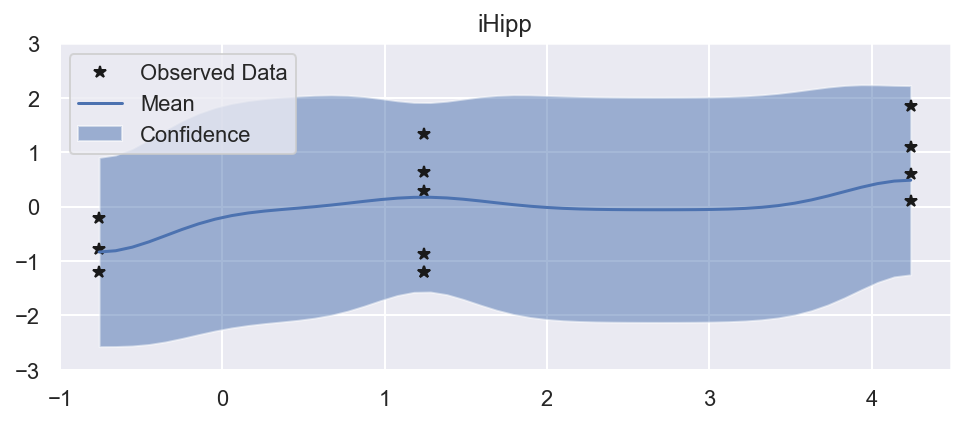

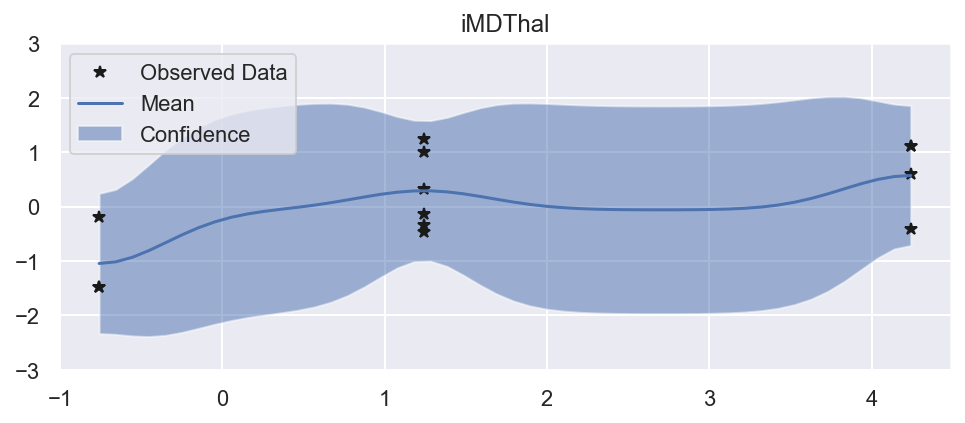

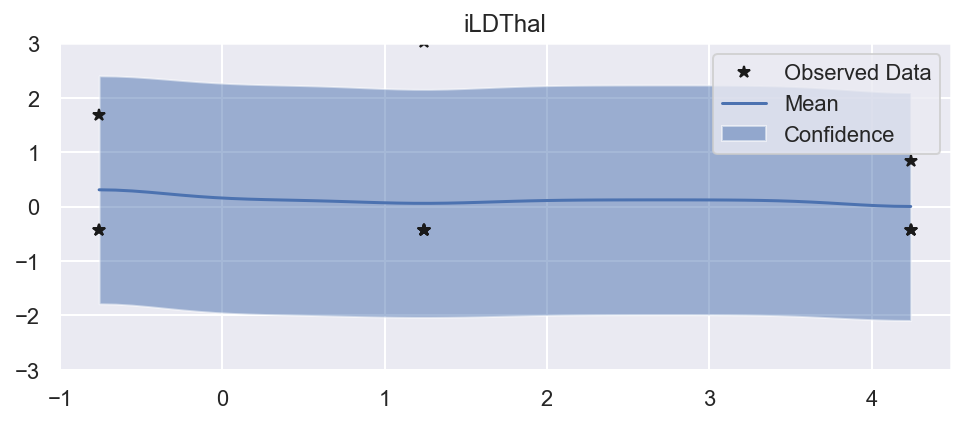

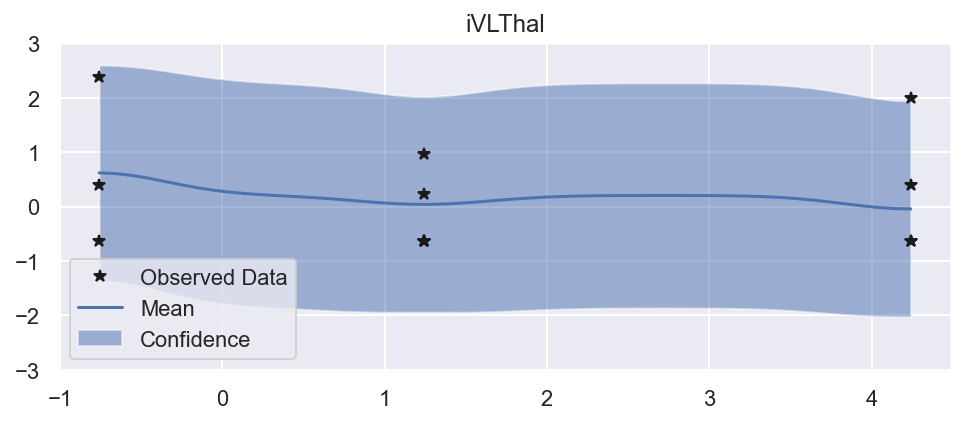

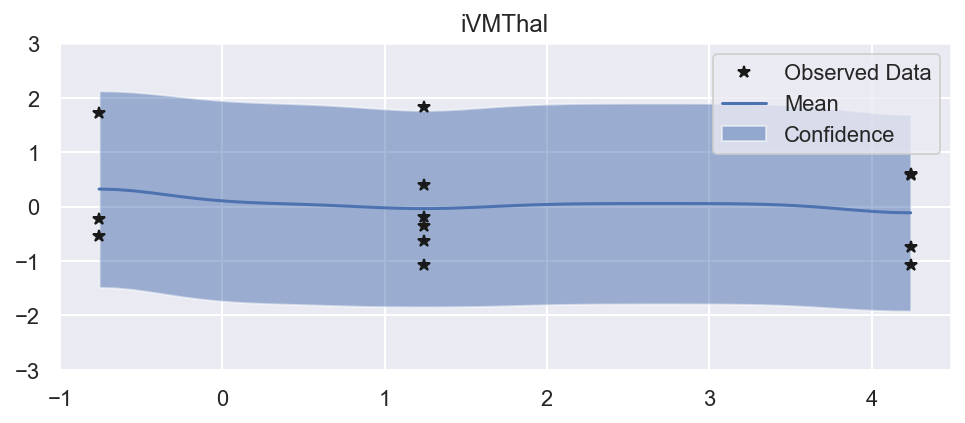

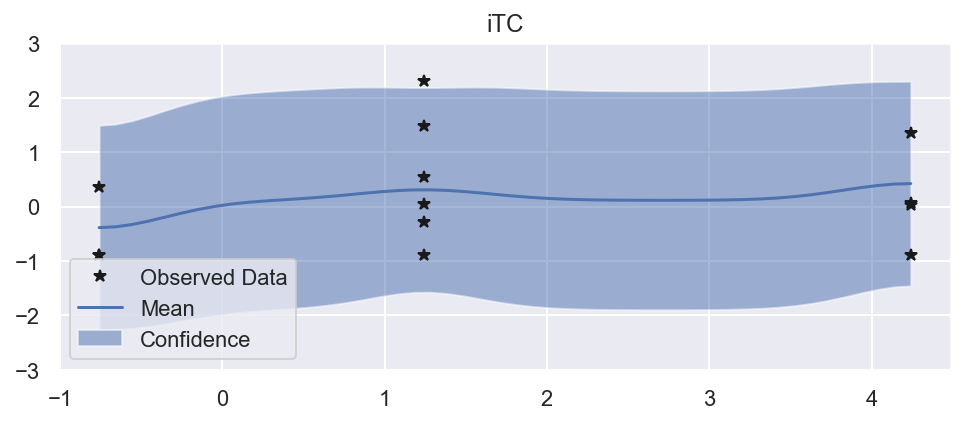

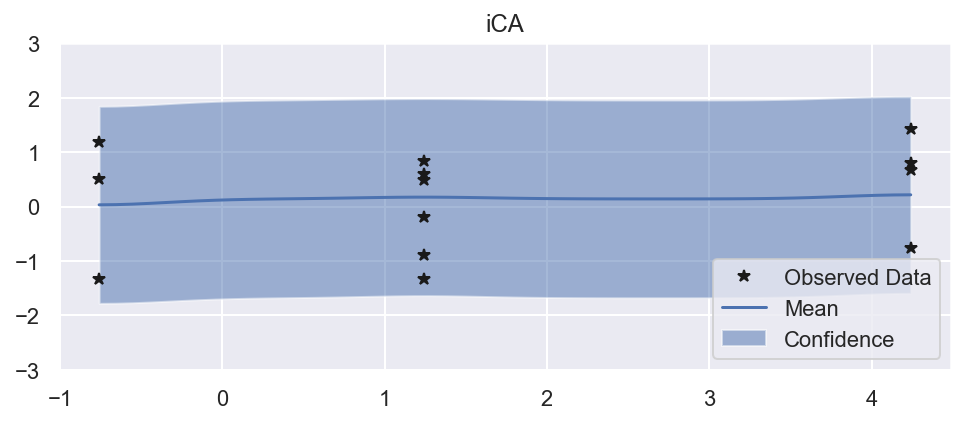

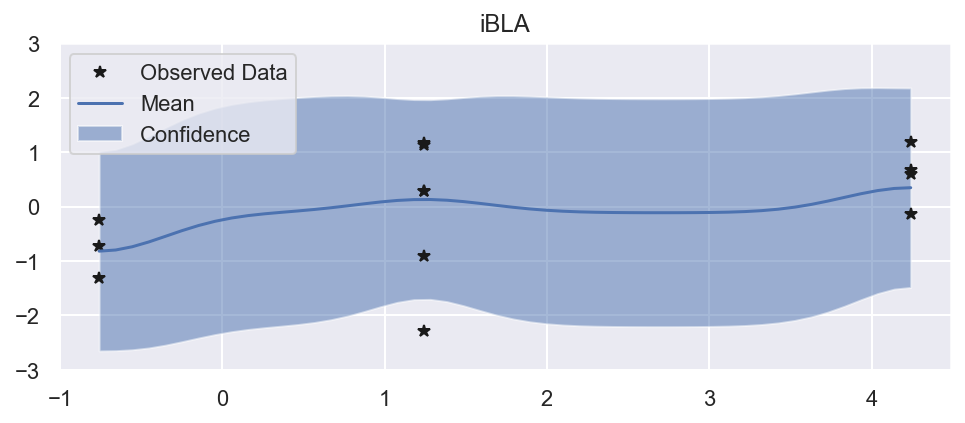

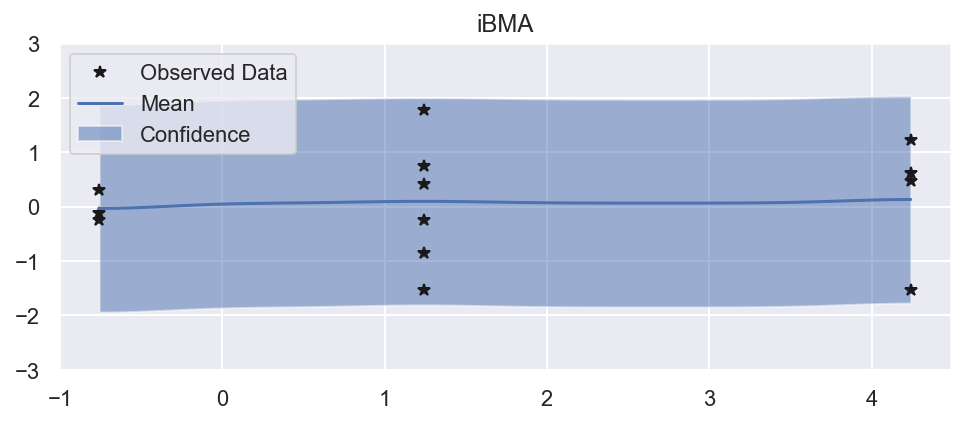

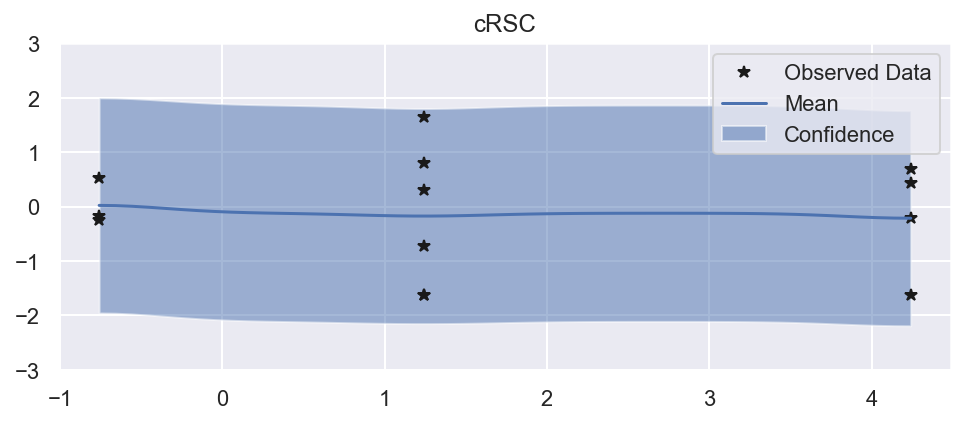

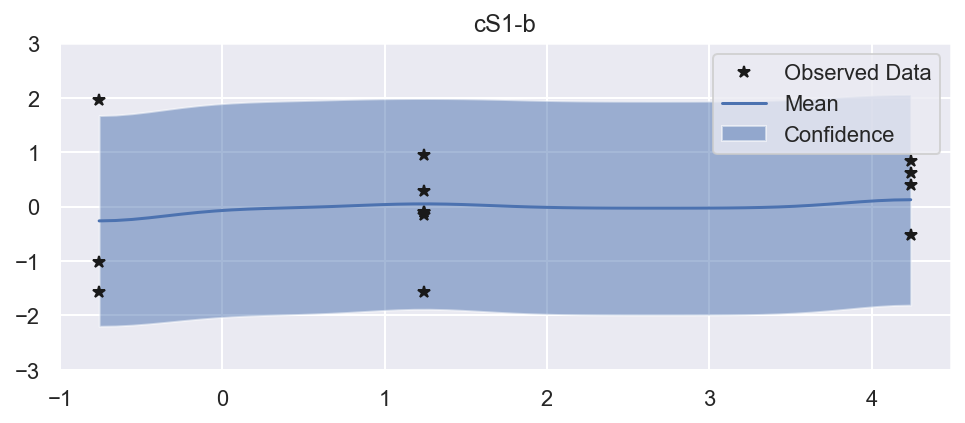

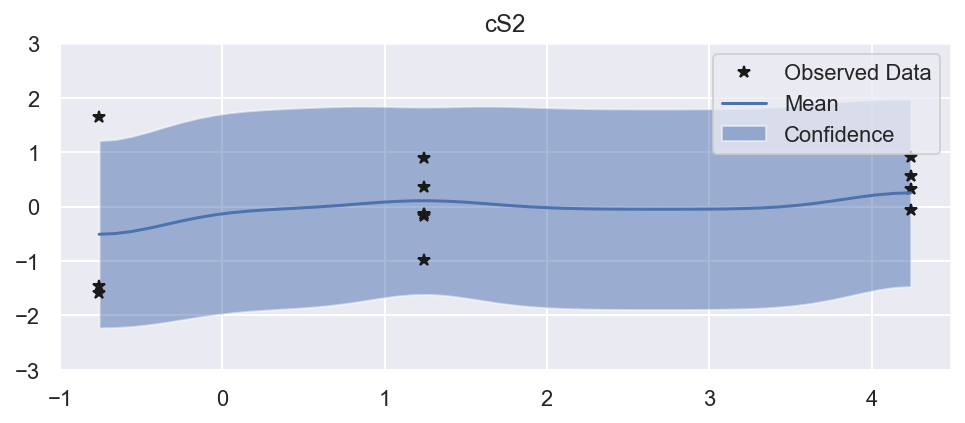

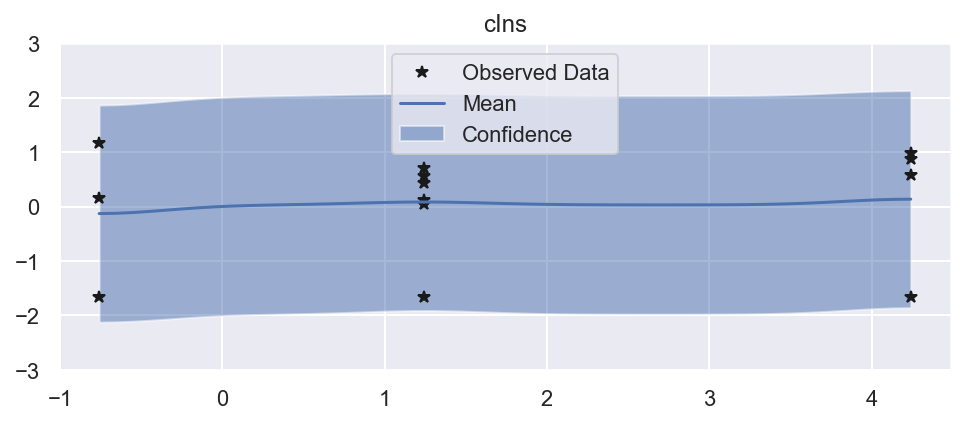

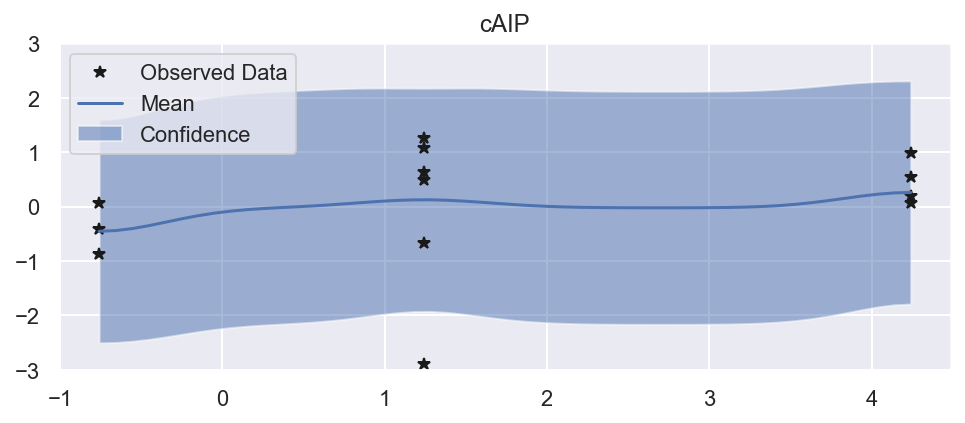

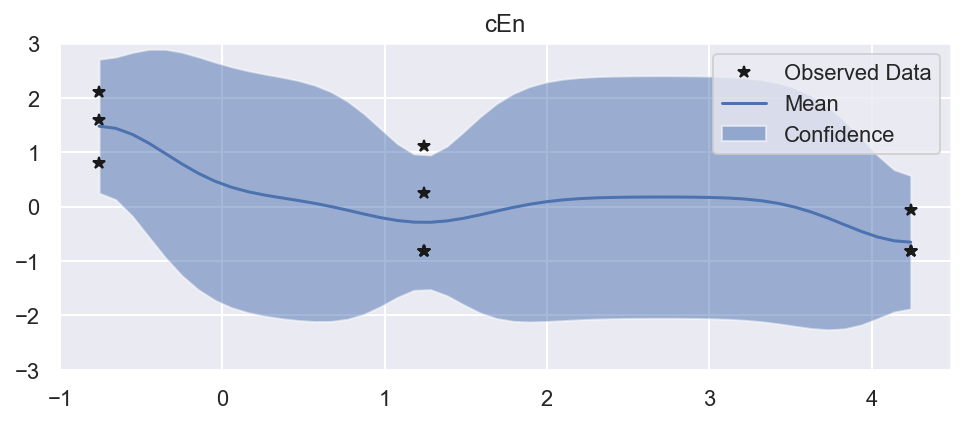

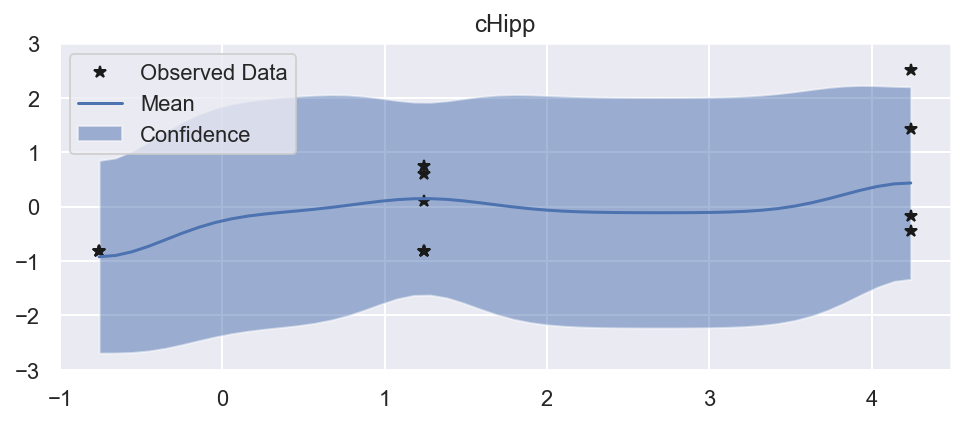

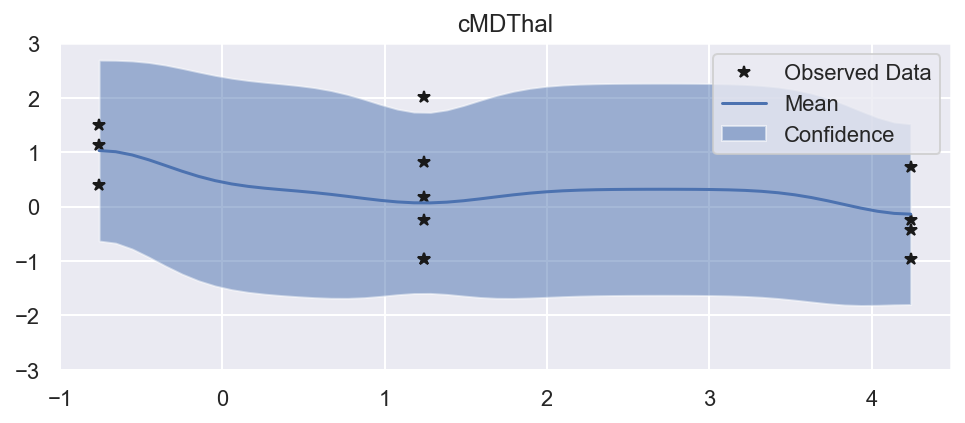

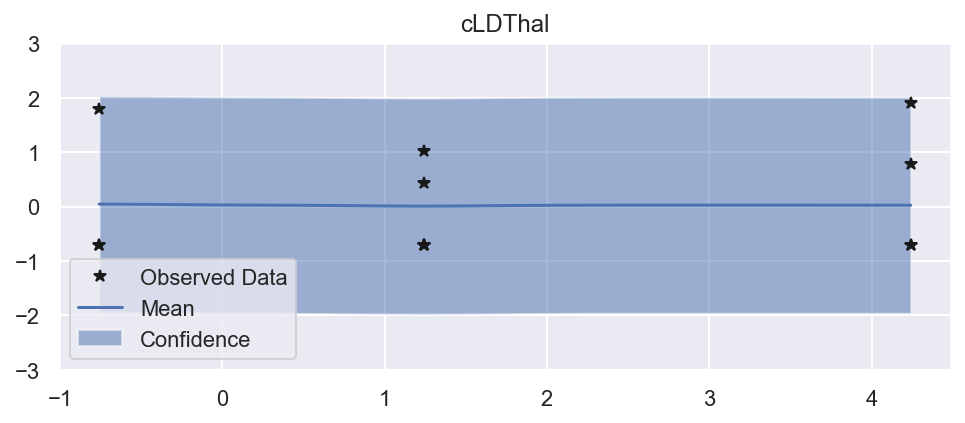

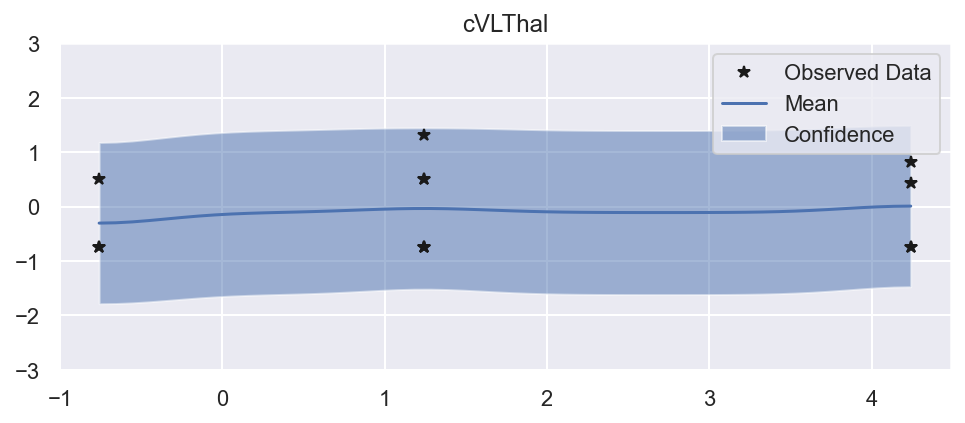

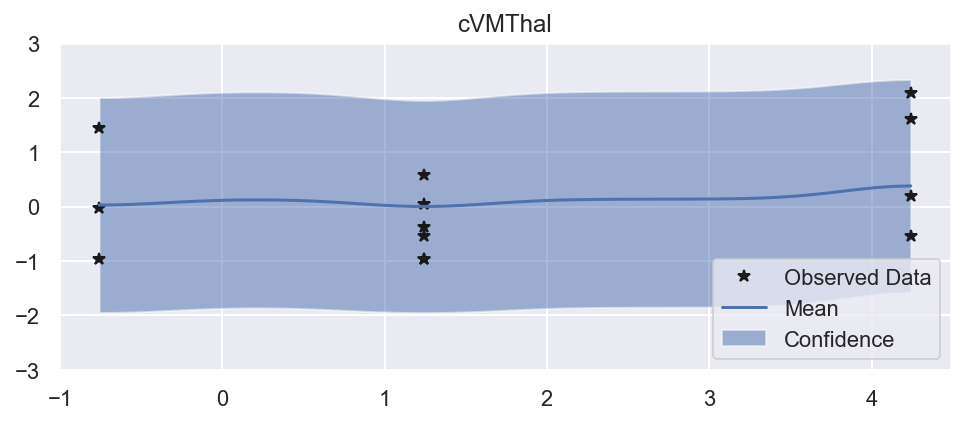

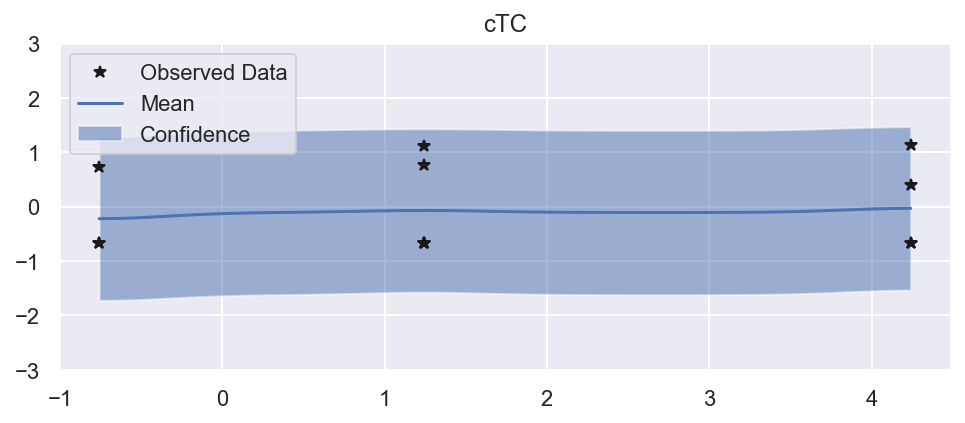

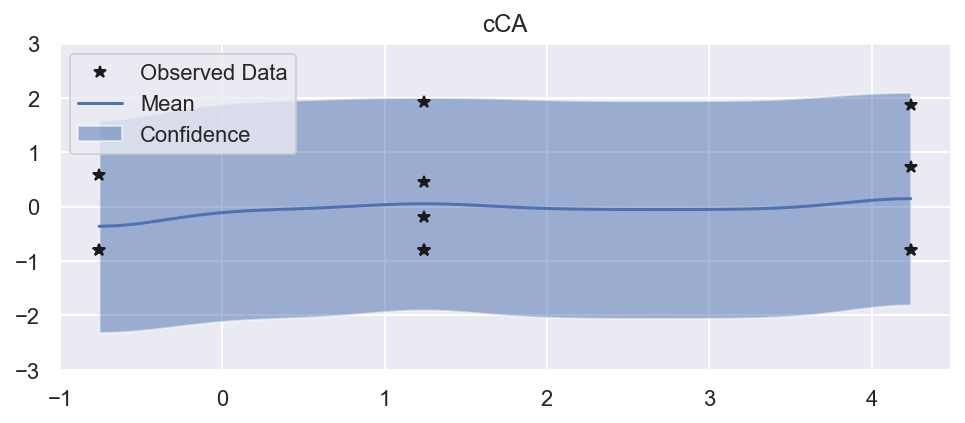

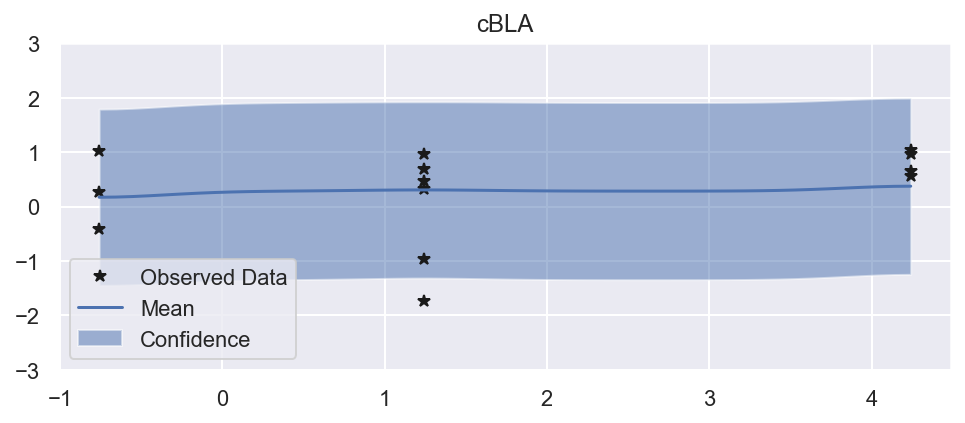

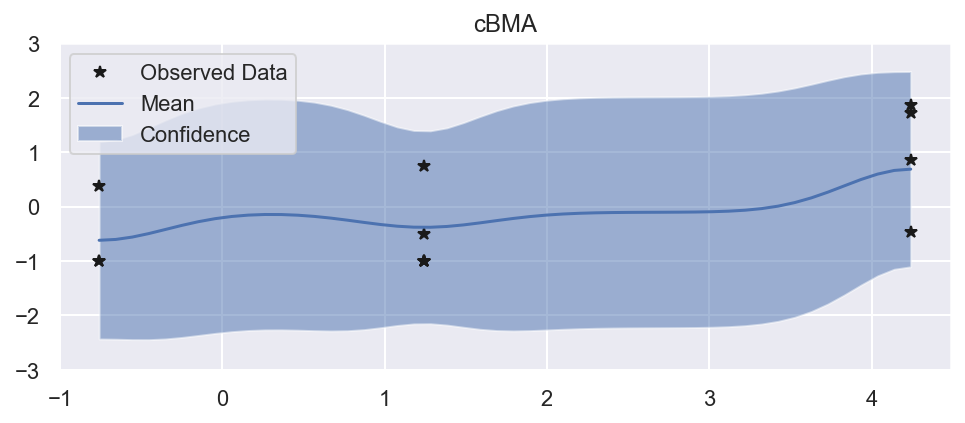

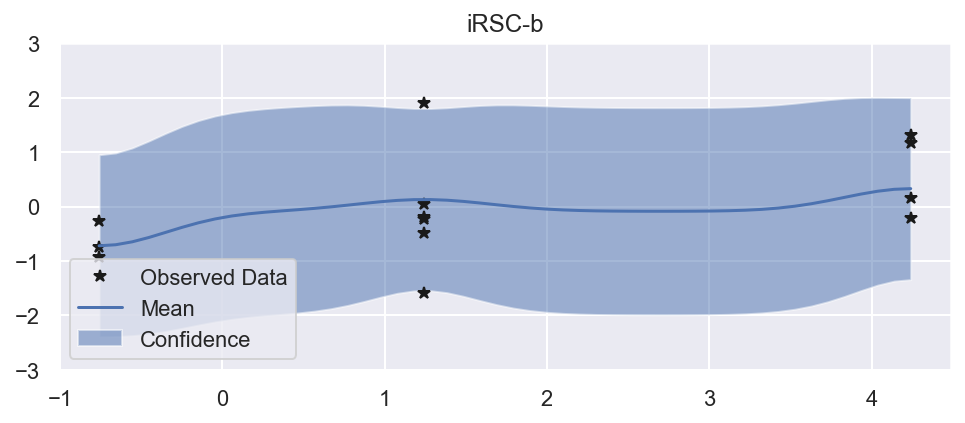

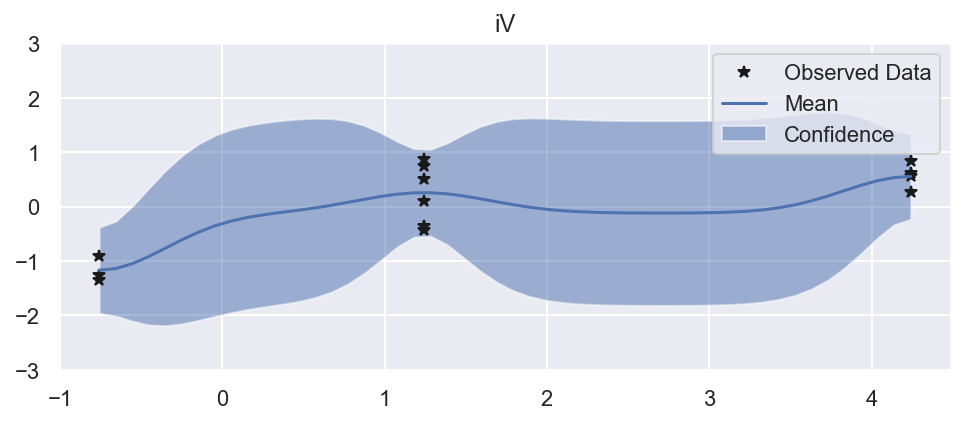

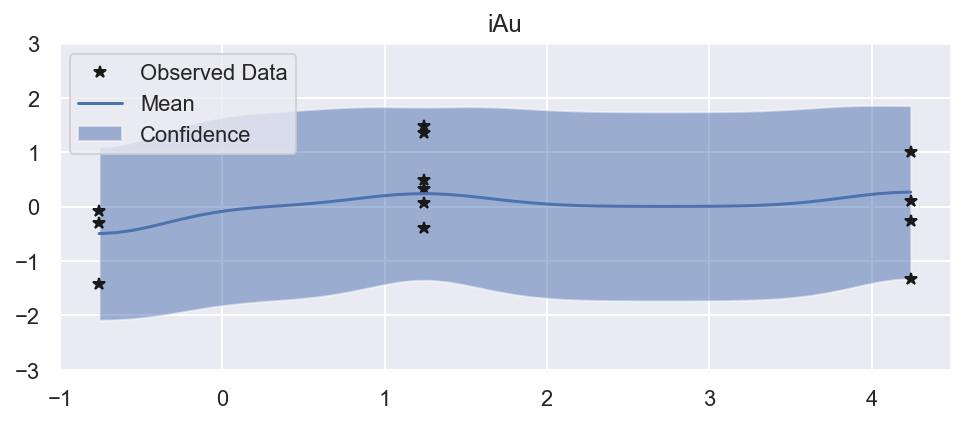

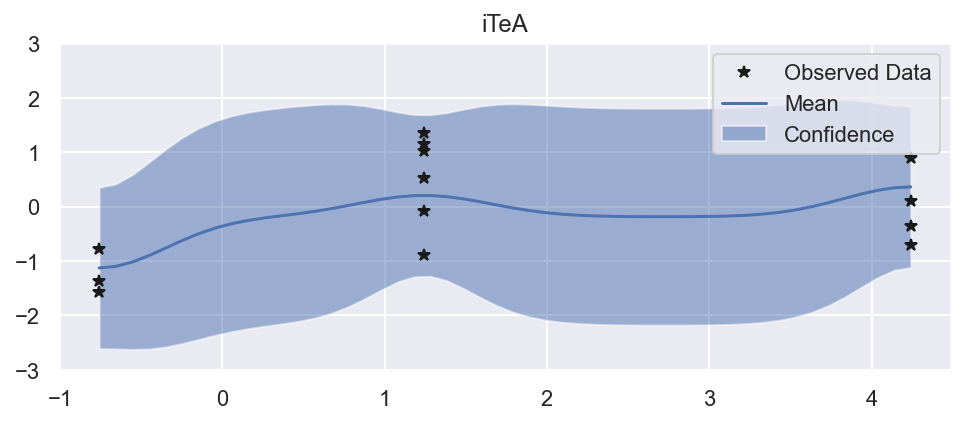

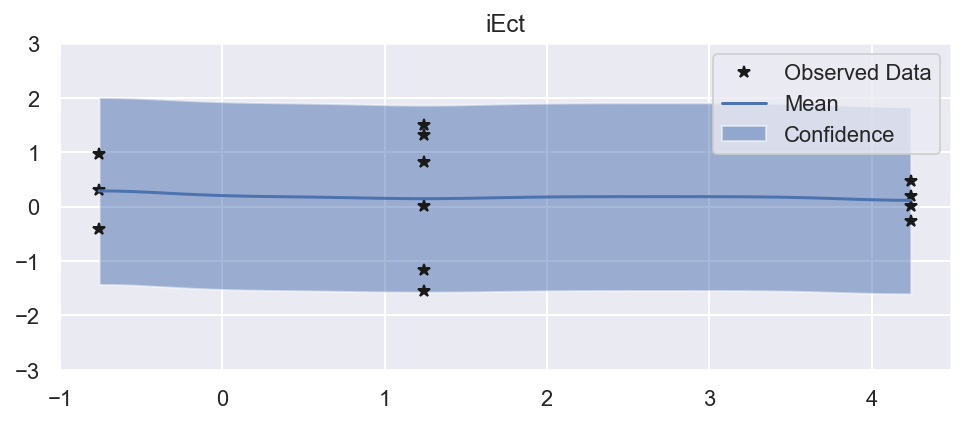

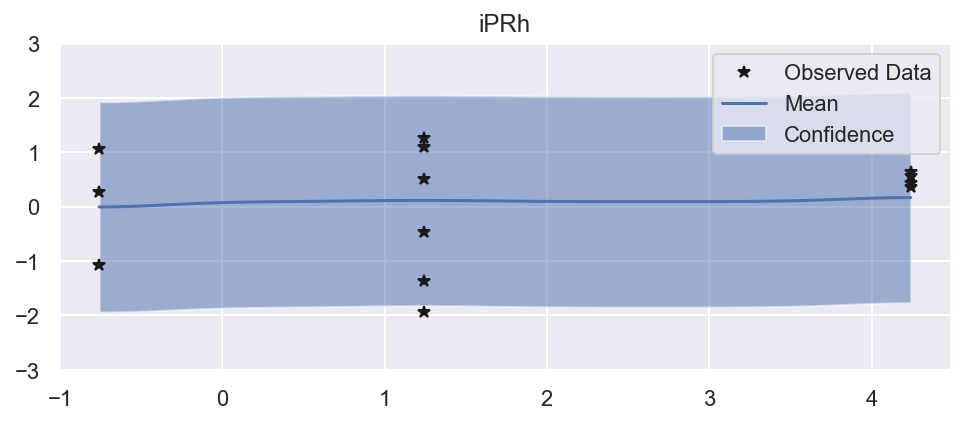

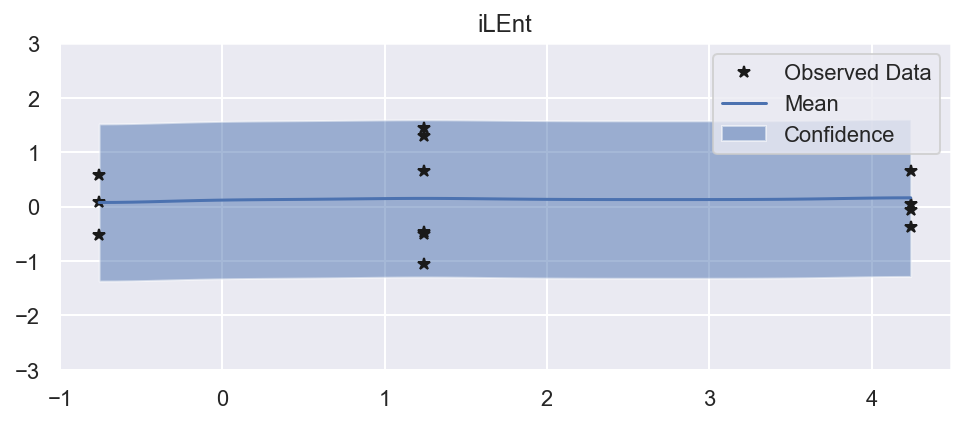

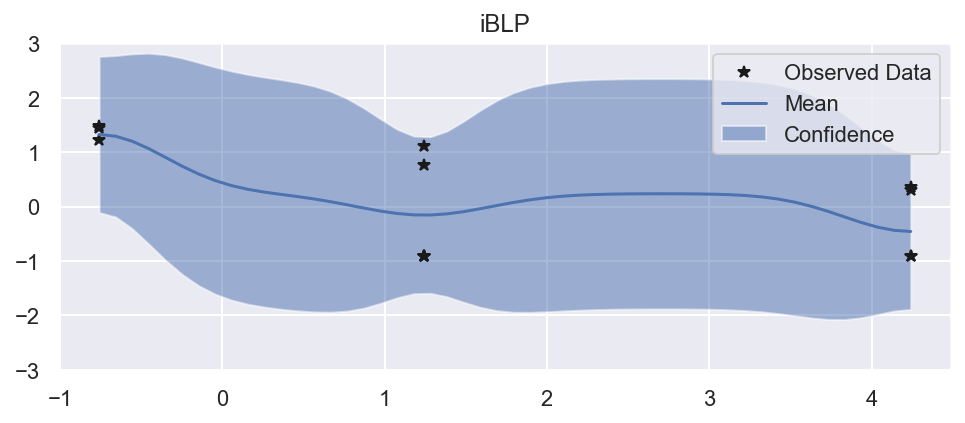

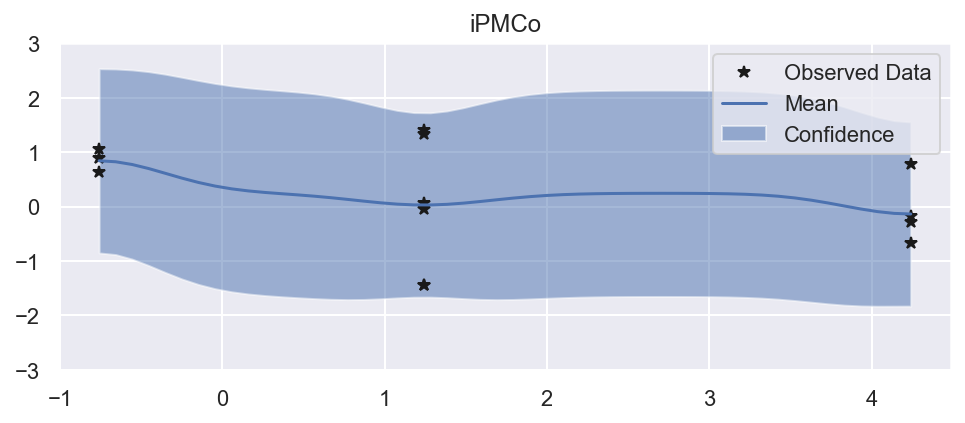

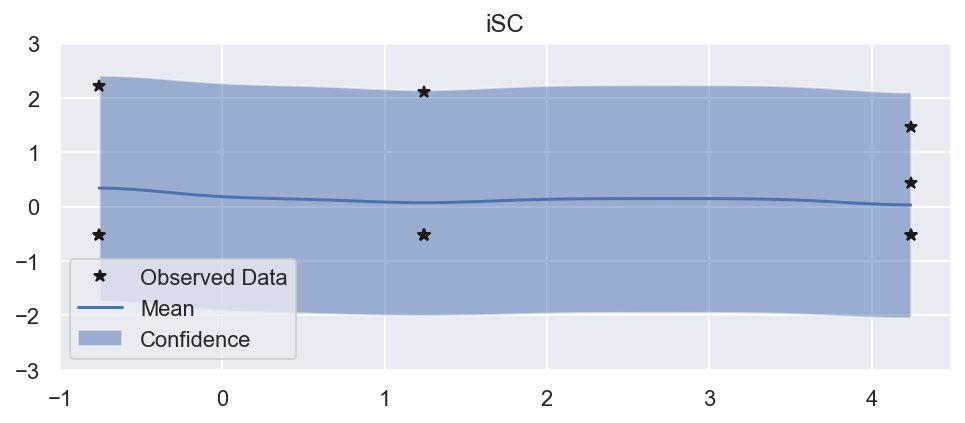

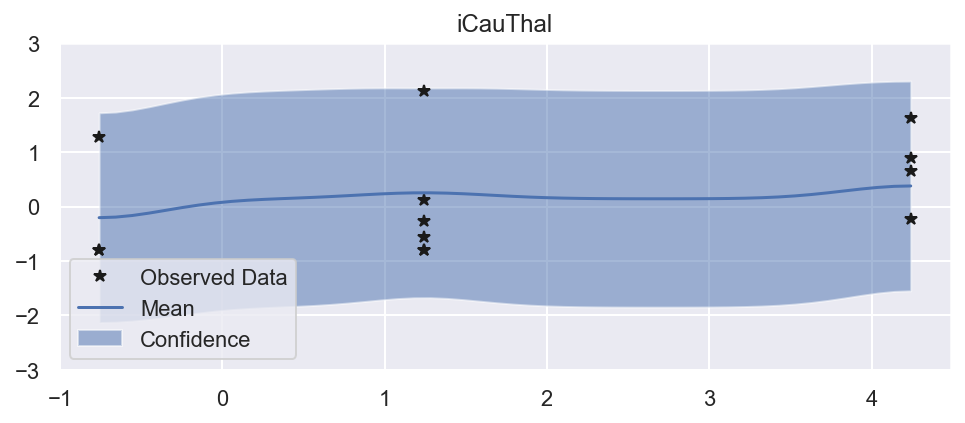

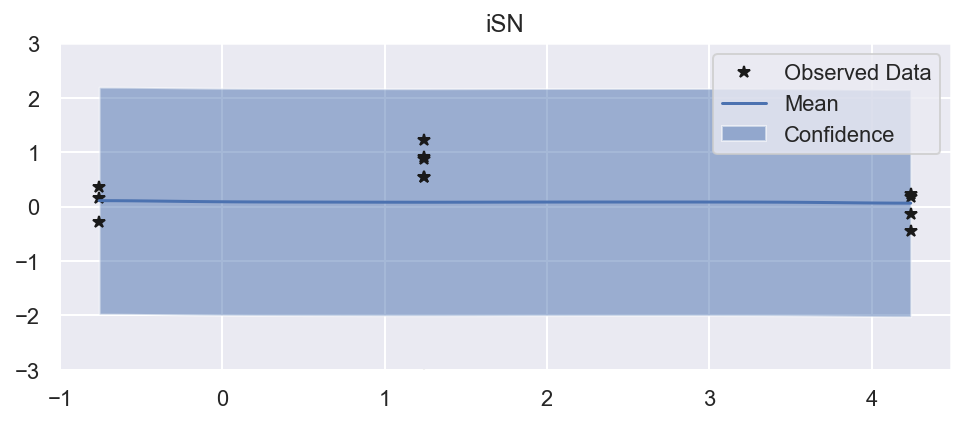

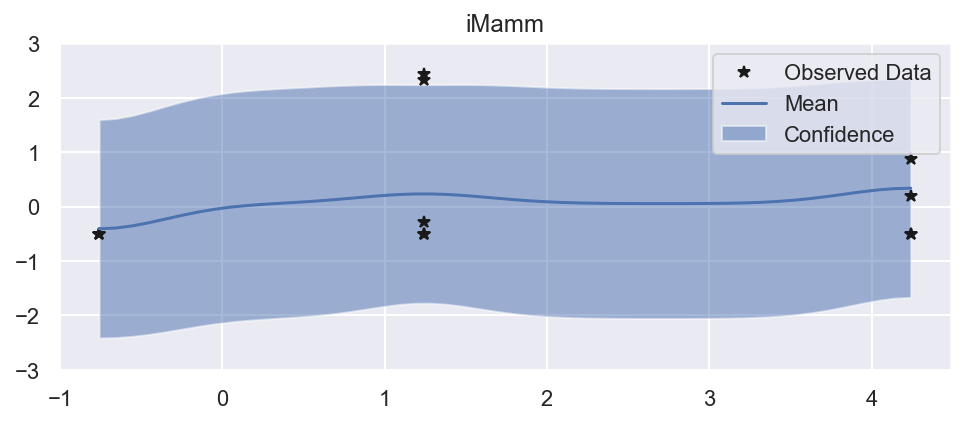

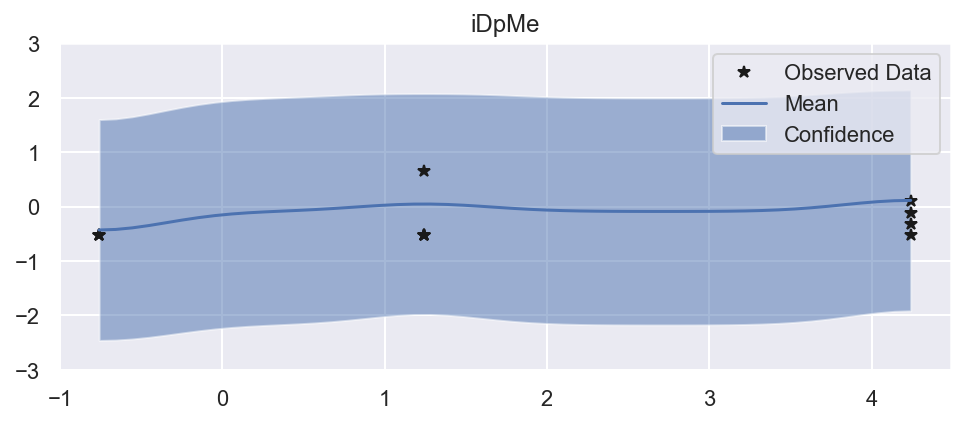

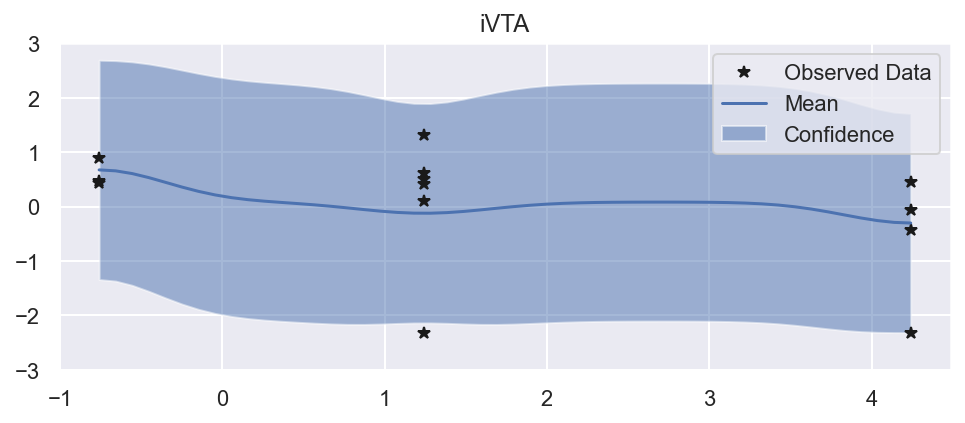

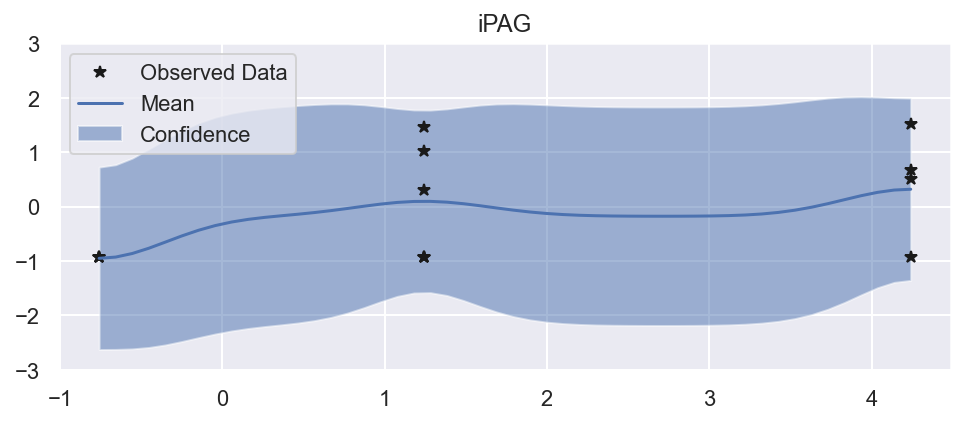

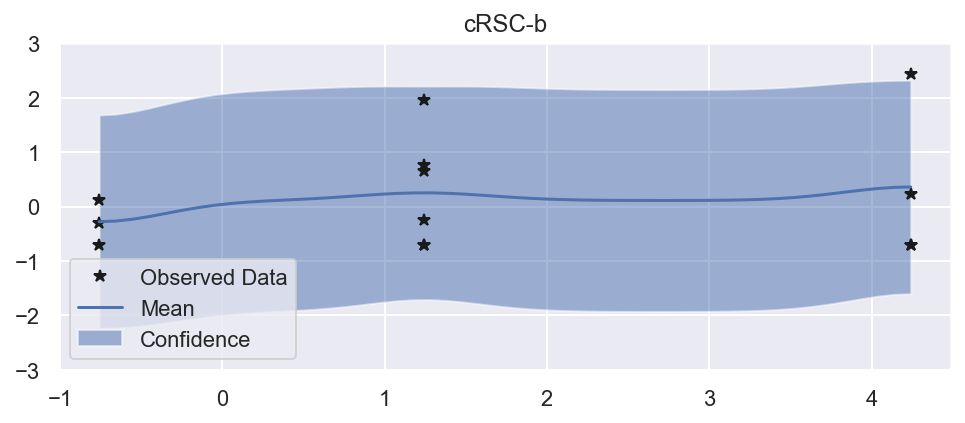

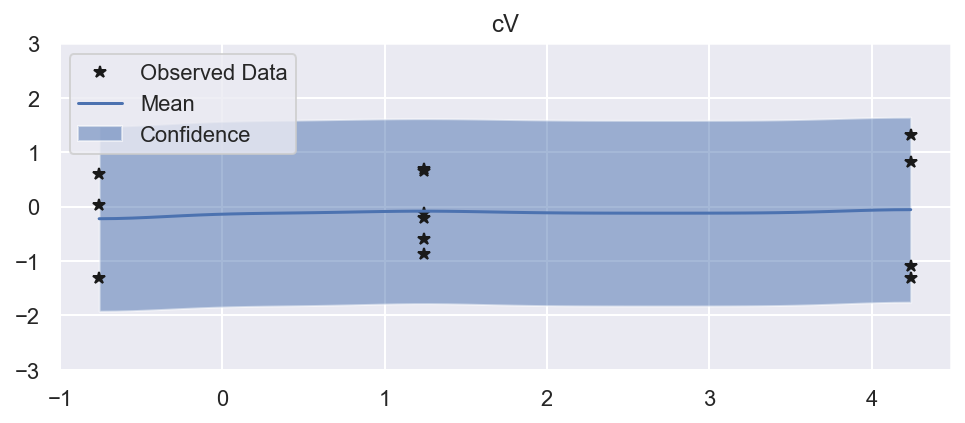

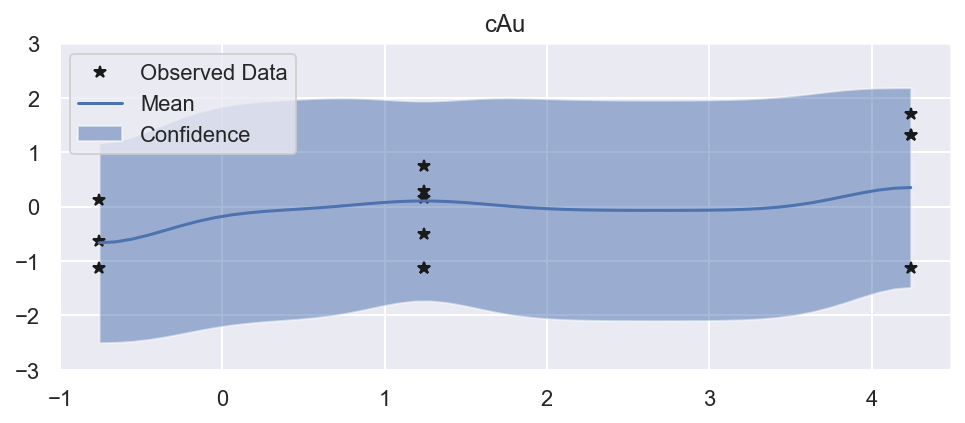

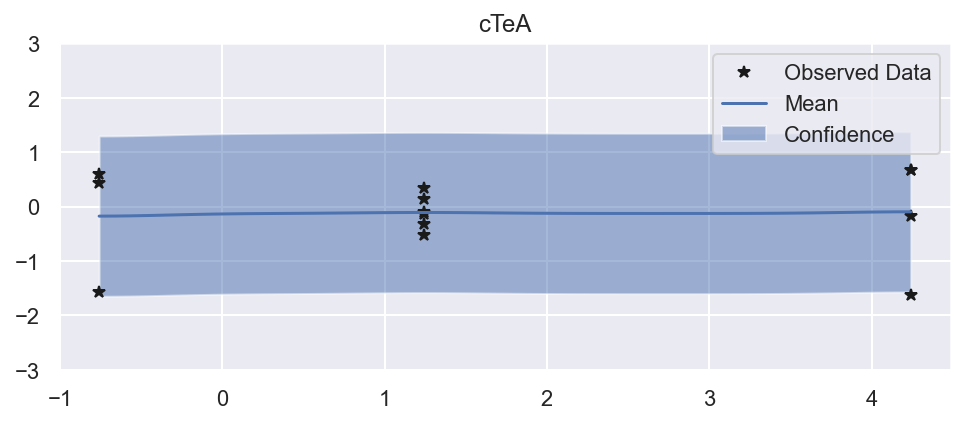

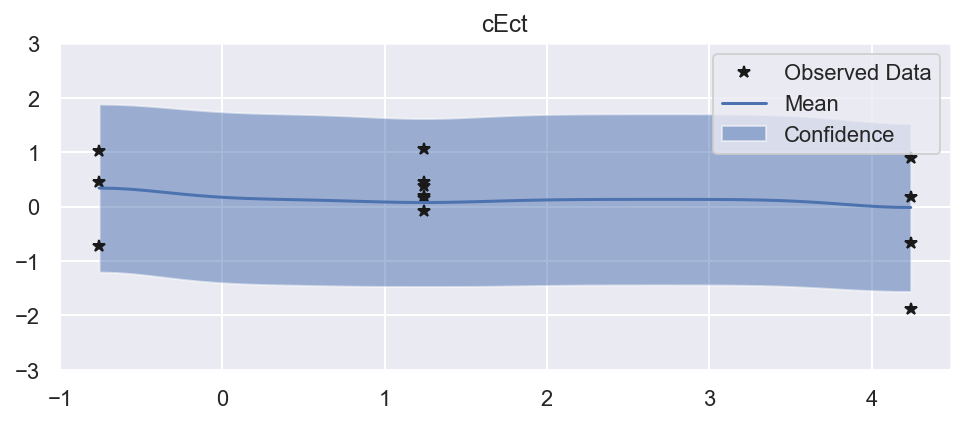

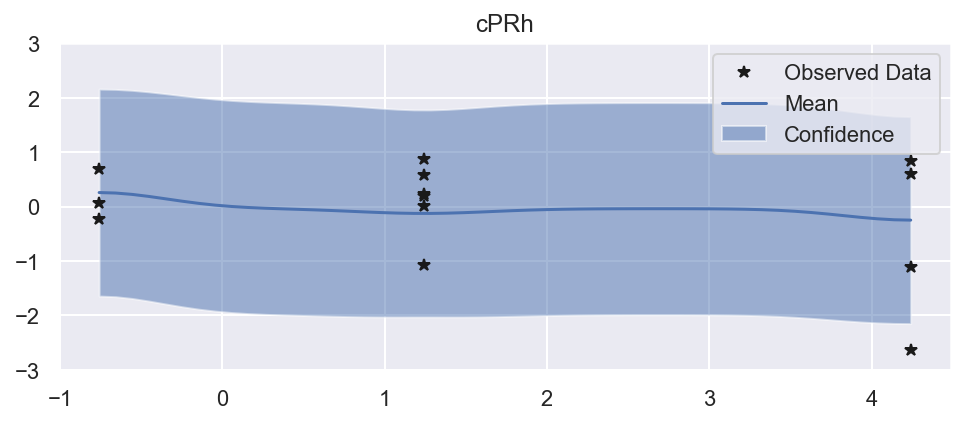

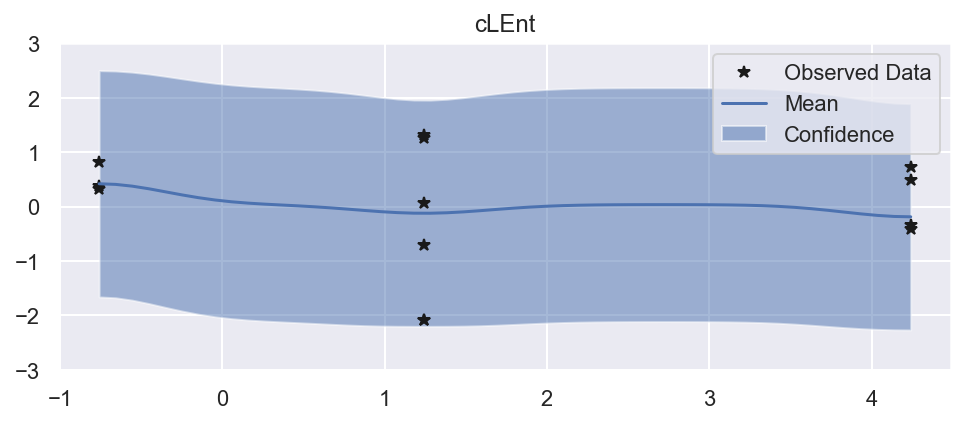

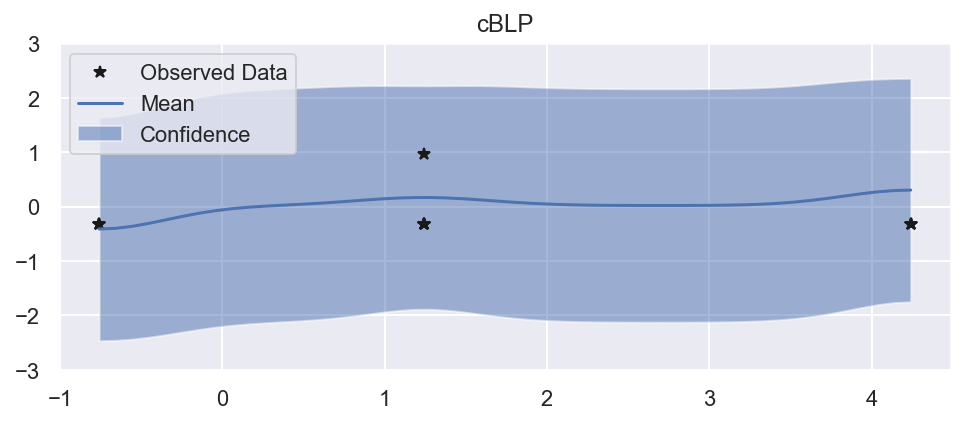

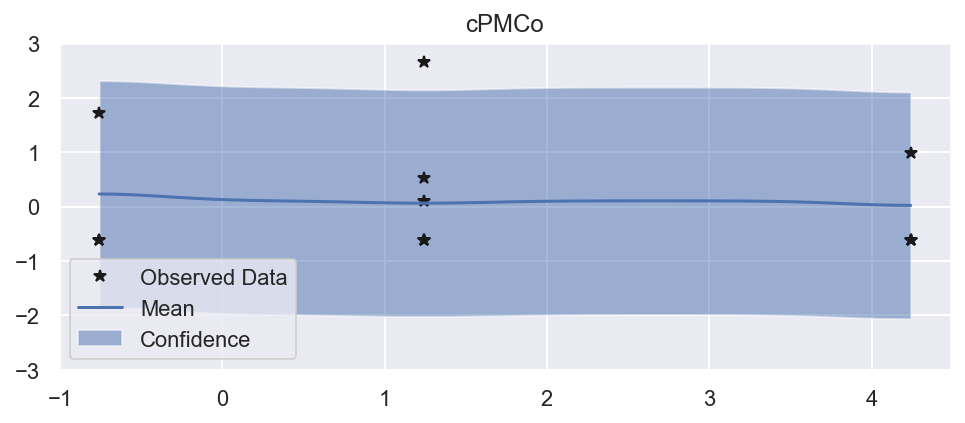

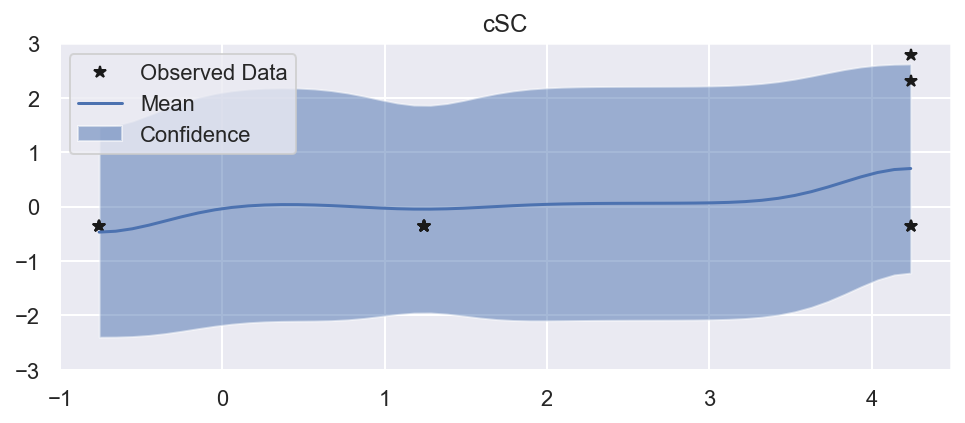

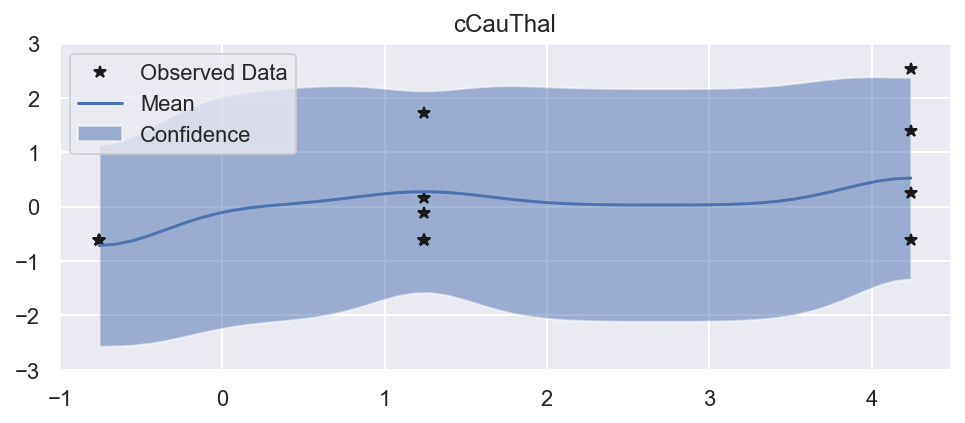

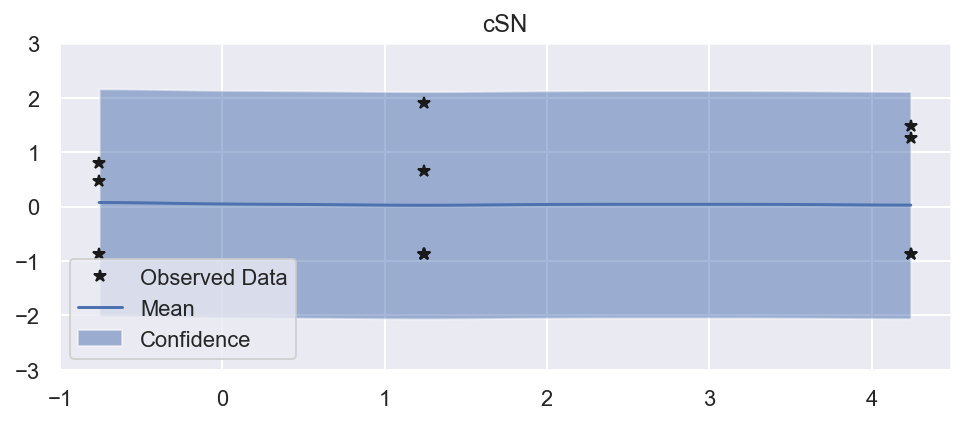

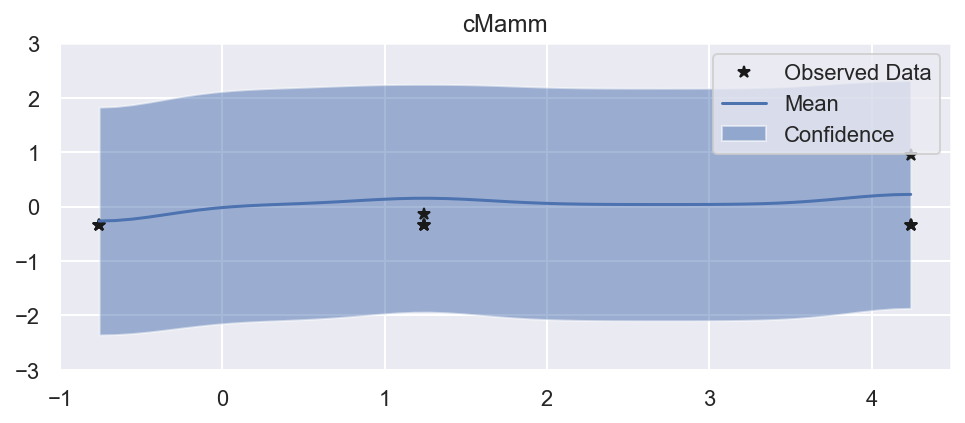

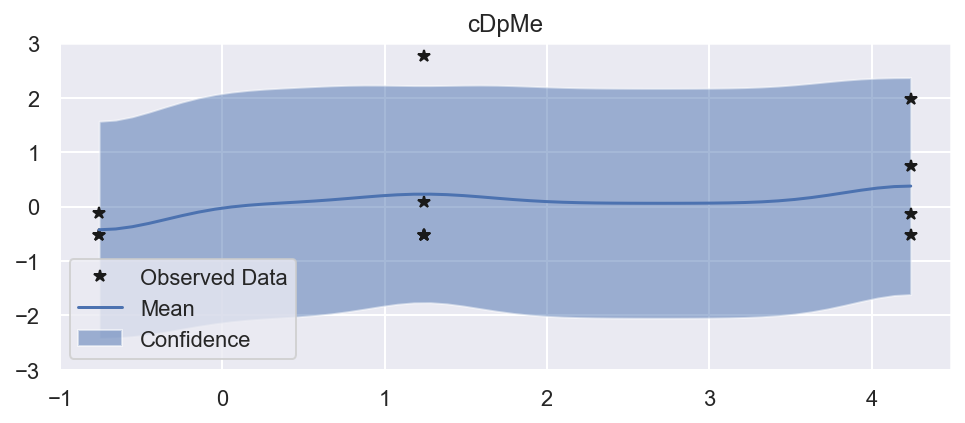

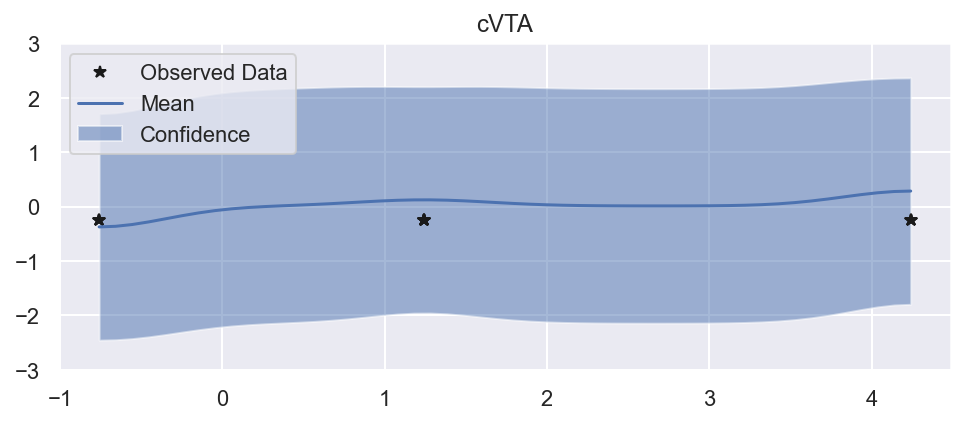

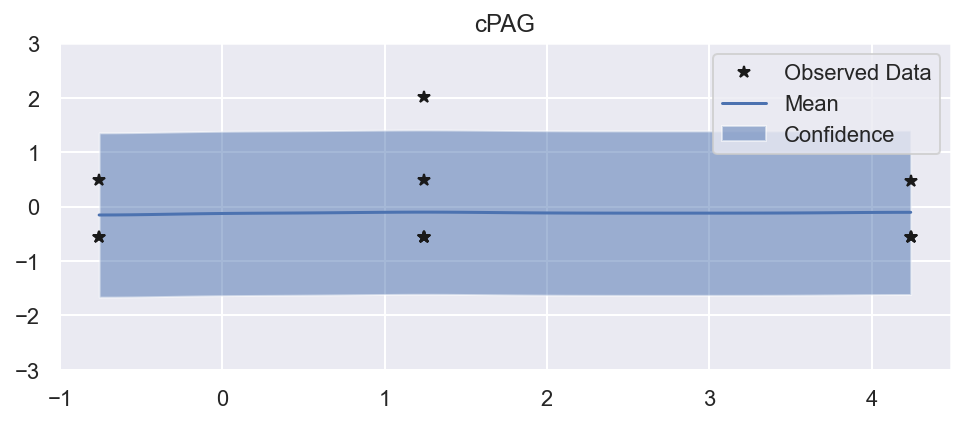

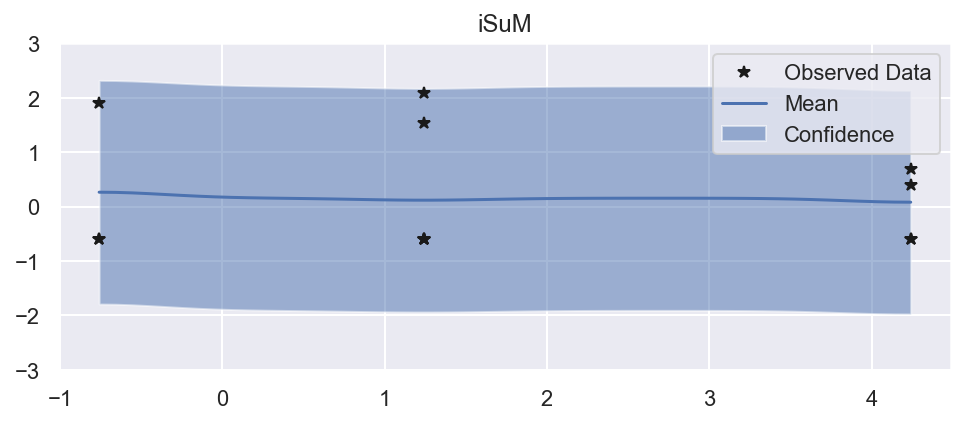

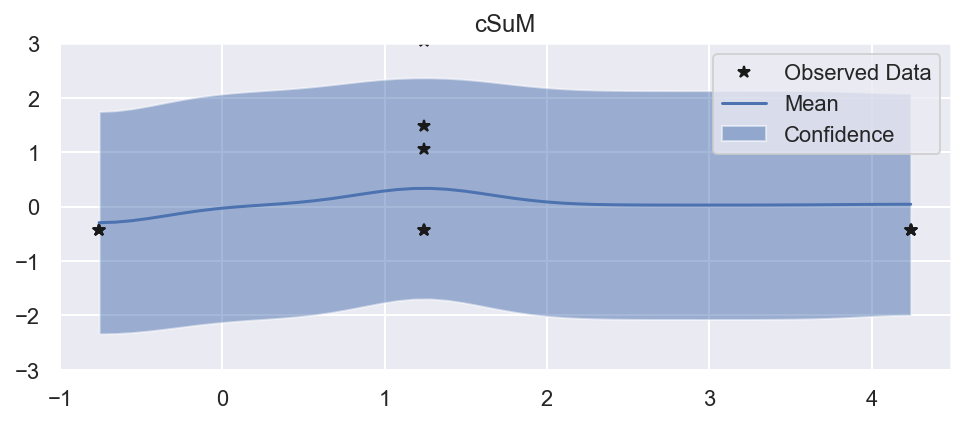

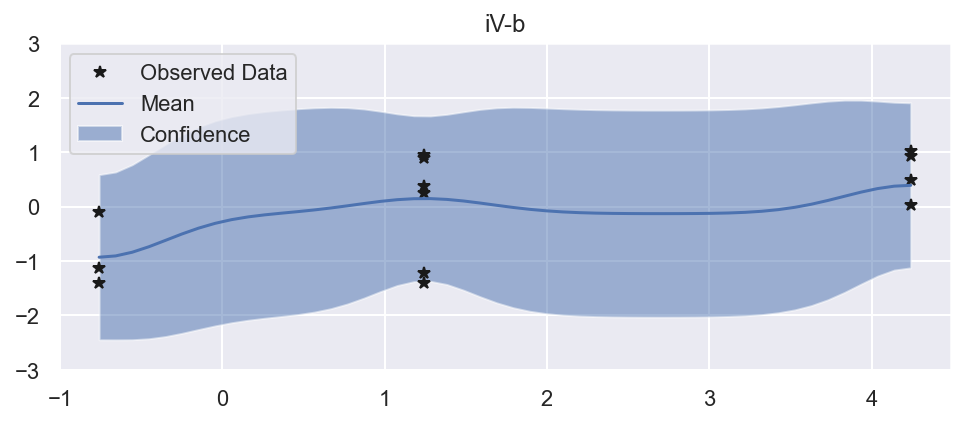

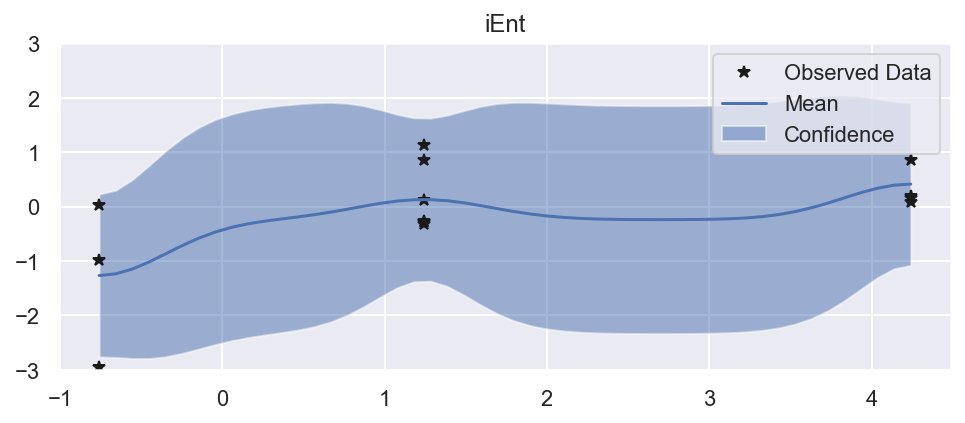

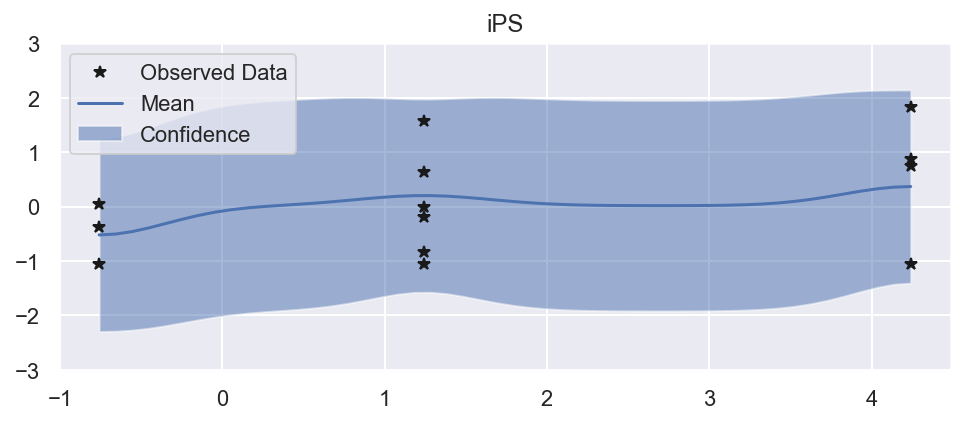

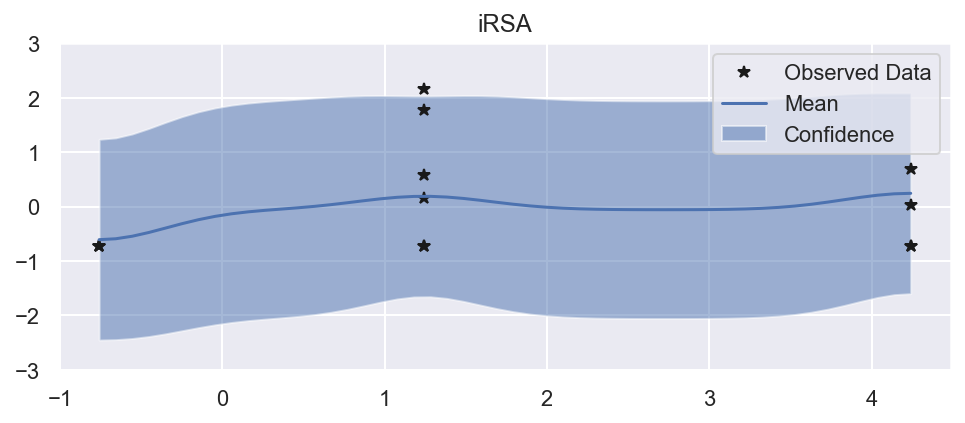

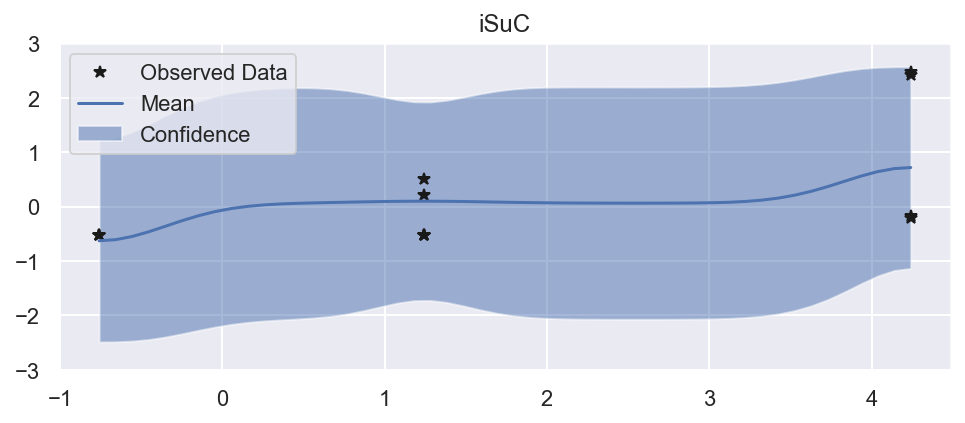

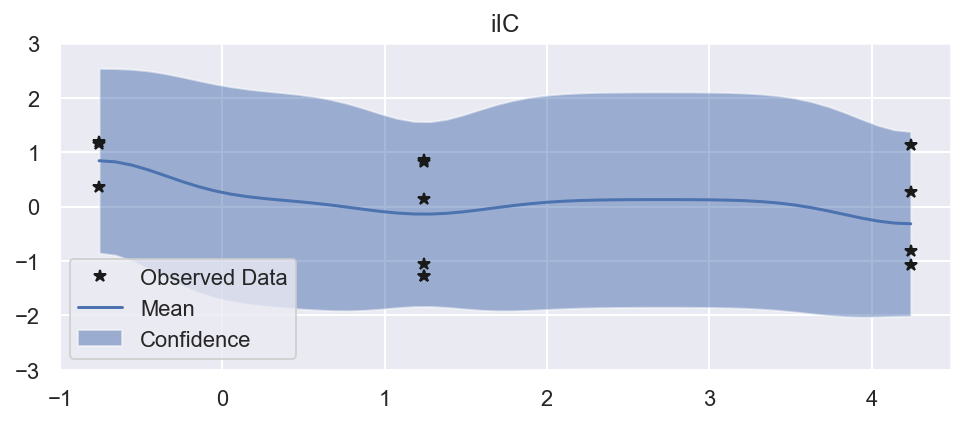

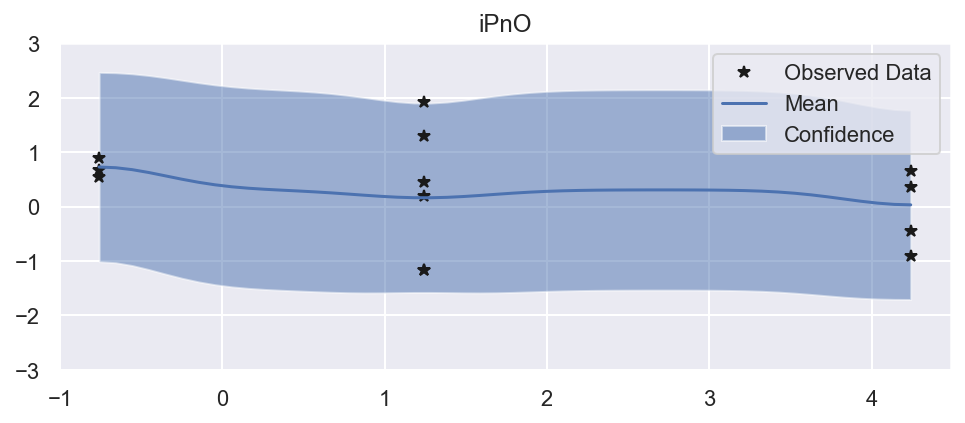

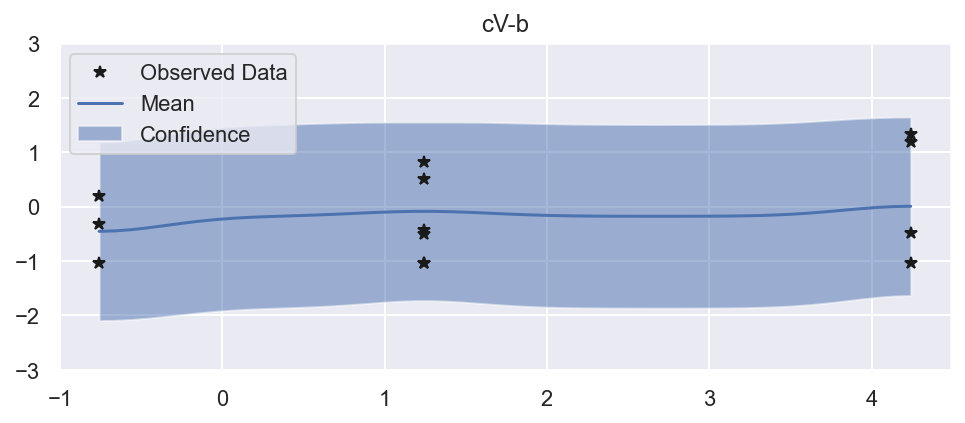

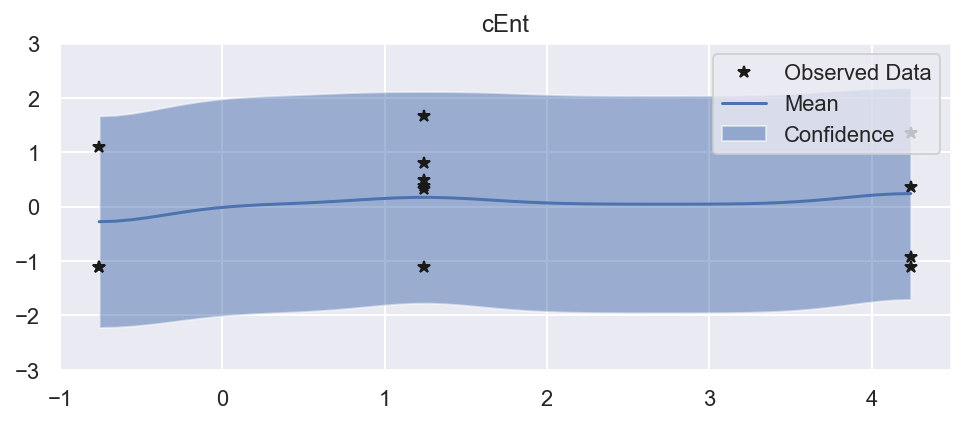

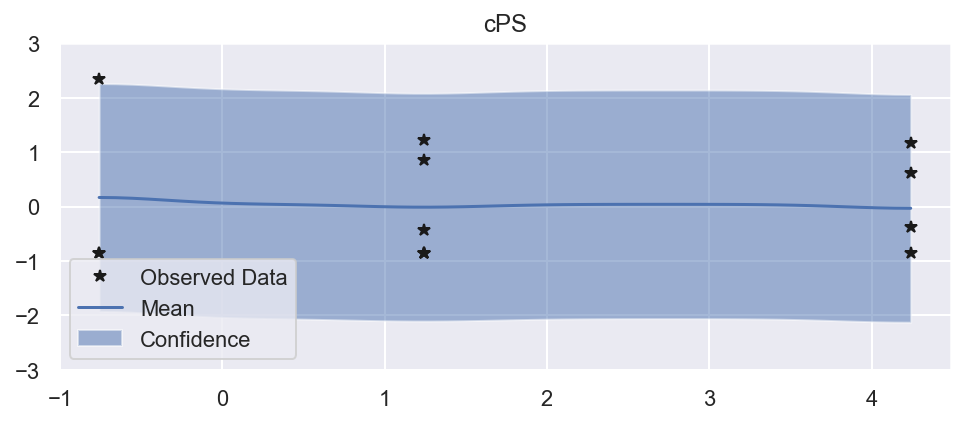

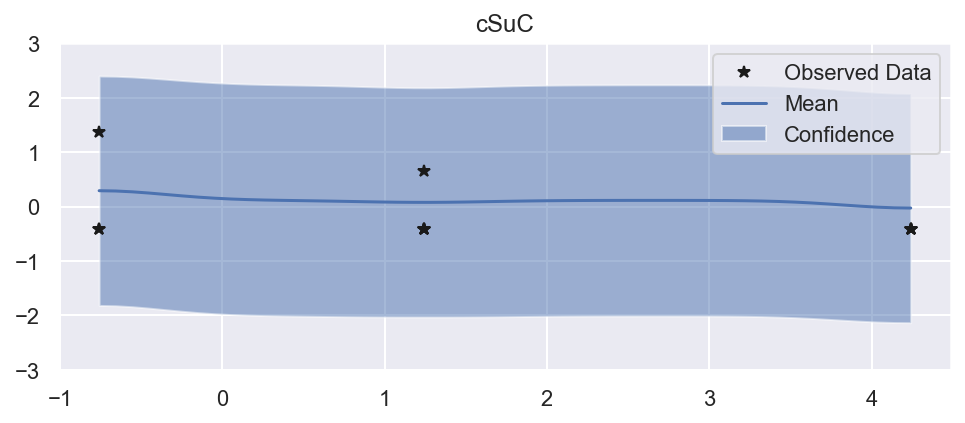

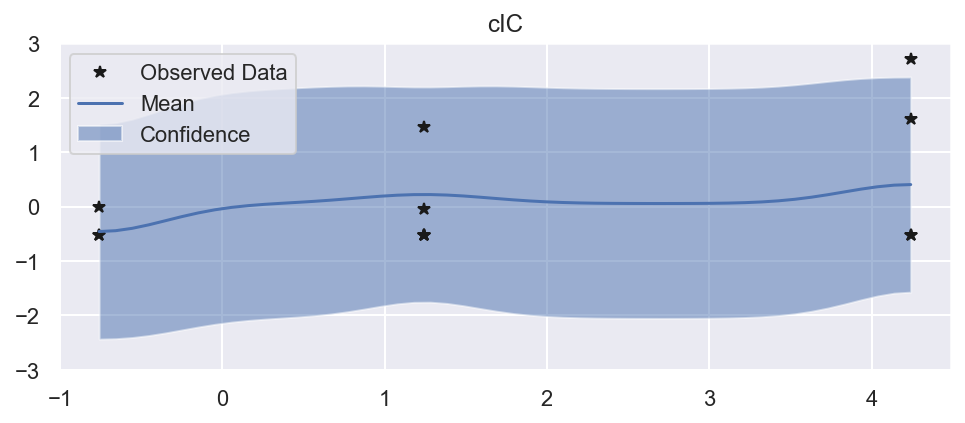

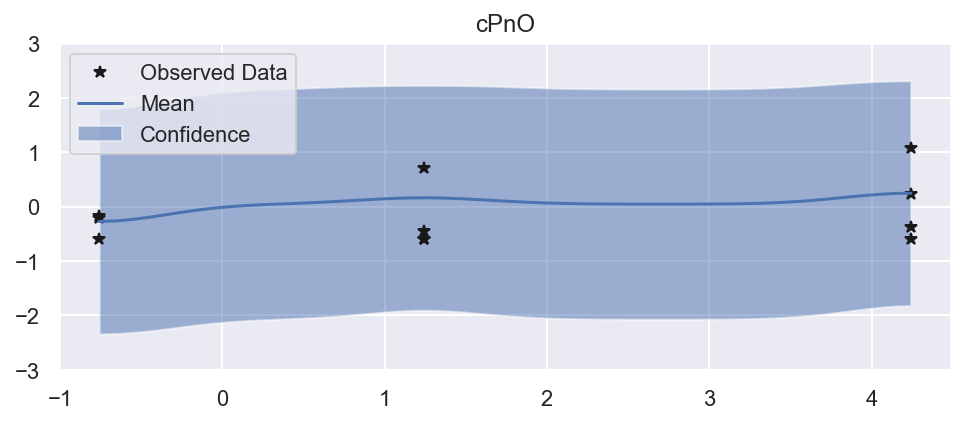

In [212]:
for c in column:
    want_to_see = column.index(c)
    
    # This contains predictions for both tasks, flattened out
    # The first half of the predictions is for the first task
    # The second half is for the second task

    # Initialize plots
    f, ax = plt.subplots(figsize=(8, 3))

    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y[:, want_to_see].detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean[:, want_to_see].numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.numpy(), lower[:, want_to_see].numpy(), upper[:, want_to_see].numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(f'{c}')
    plt.show()

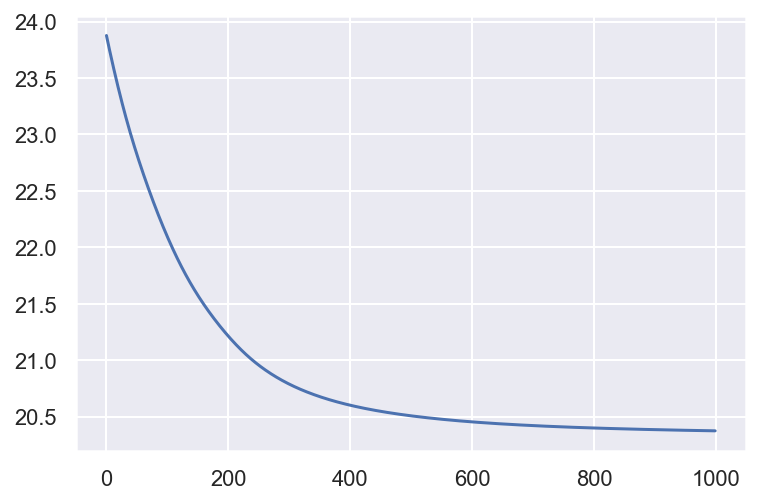

In [194]:
plt.plot(hist_loss)

In [125]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * np.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * np.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

In [177]:
train_x = torch.rand((16,))
train_y = torch.rand((16, 116))
print(train_x.shape)
print(train_y.shape)
print(train_x.dtype)
print(train_y.dtype)
print(train_x.stride())
print(train_y.stride())

torch.Size([16])
torch.Size([16, 116])
torch.float32
torch.float32
(1,)
(116, 1)
